## Digital Image Processing Project (Group IV)

Given two images (left and right view) and camera calibration details, the goal is to find the 
relative depth of various objects in the image using stereo vision.

### DataSet used : https://drivingstereo-dataset.github.io/
10 Images are taken at random from the left-right vision folders as well as from the rainy / foggy folder.

In [ ]:
# Import third party libs.
import numpy as np
import cv2
import os
import PIL
from PIL import Image
import glob
import matplotlib.pyplot as plt
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import math

import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def blur_images(images):
  blurred_images = [] * len(images) 

  for img in images:
      # kernel is of size 9x9
      blur_kernel = np.ones((9, 9), np.float32) / (9.0 * 9.0)
      gaussian_blur = cv2.GaussianBlur(img, (9, 9), 0)
      blurred_images.append(gaussian_blur)

  return blurred_images

### Bit plane slicing


In [ ]:
def bit_plane_slicing(images):
  for img in images:
    cv2_imshow(img)
    lst=[]
    for j in range(img.shape[0]):
      for k in range(img.shape[1]):
        lst.append(str(format((img[j][k]),'08b')))
    eight_bit_img = (np.array([int(i[0]) for i in lst],dtype = np.uint8) * 128).reshape(img.shape[0],img.shape[1])
    seven_bit_img = (np.array([int(i[1]) for i in lst],dtype = np.uint8) * 64).reshape(img.shape[0],img.shape[1])
    six_bit_img = (np.array([int(i[2]) for i in lst],dtype = np.uint8) * 32).reshape(img.shape[0],img.shape[1])
    five_bit_img = (np.array([int(i[3]) for i in lst],dtype = np.uint8) * 16).reshape(img.shape[0],img.shape[1])
    four_bit_img = (np.array([int(i[4]) for i in lst],dtype = np.uint8) * 8).reshape(img.shape[0],img.shape[1])
    three_bit_img = (np.array([int(i[5]) for i in lst],dtype = np.uint8) * 4).reshape(img.shape[0],img.shape[1])
    two_bit_img = (np.array([int(i[6]) for i in lst],dtype = np.uint8) * 2).reshape(img.shape[0],img.shape[1])
    one_bit_img = (np.array([int(i[7]) for i in lst],dtype = np.uint8) * 1).reshape(img.shape[0],img.shape[1])
    final1=cv2.hconcat([eight_bit_img,seven_bit_img,six_bit_img,five_bit_img])
    final2=cv2.hconcat([four_bit_img,three_bit_img,two_bit_img,one_bit_img])
    final=cv2.hconcat([final1,final2])
    print("The 8 bit planes: ")
    cv2_imshow(final)

## Histogram Equalization

In [ ]:
def histogram_eq(images):
  for img in images:
    print("Original image: ")
    cv2_imshow(img)
    #flatten image array and calculate histogram via binning
    histogram_array=np.bincount(img.flatten(),minlength=256)
    #normalize
    num_pixels = np.sum(histogram_array)
    histogram_array = histogram_array/num_pixels
    #normalized cumulative histogram
    chistogram_array = np.cumsum(histogram_array) #cumsum returns cumulative sum of array elements over a given axis
    transform_map = np.floor(255 * chistogram_array).astype(np.uint8) #pixel mapping lookup table
    #flattening image into 1D array
    img_list = list(img.flatten())
    eq_img_list = [transform_map[p] for p in img_list]#transform pixel values to equalize
    eq_img_array = np.reshape(np.asarray(eq_img_list), img.shape)#reshape and write back into an image array
    print("Histogram Equalized Image: ")
    cv2_imshow(eq_img_array)

## Smoothing + Segmentation

In [ ]:
def smoothing_segmentation(images):
  print("Smoothing + segmented images")
  for img in images:
    dims=img.shape
    mean_fil=np.zeros([dims[0],dims[1]])
    for i in range(1,dims[0]-1):
      for j in range(1,dims[1]-1):
        neighbours = [img[i-1,j-1],
                    img[i-1,j],
                    img[i-1,j+1],
                    img[i,j-1],
                    img[i,j],
                    img[i,j+1],
                    img[i+1,j-1],
                    img[i+1,j],
                    img[i+1,j+1],]
        mean_fil[i,j]=sum(neighbours)/9
        mean_fil=mean_fil.astype(np.uint8)
    
    img_shape = mean_fil.shape
    height = img_shape[0]
    width = img_shape[1]
  
    for row in range(width):
      for column in range(height):
        if mean_fil[column, row] > 127:
          mean_fil[column, row] = 255
        else:
          mean_fil[column, row] = 0
    cv2_imshow(mean_fil)

In [ ]:
!git clone https://github.com/Shankar0x/DepthSensingDatasets.git images
from PIL import Image

In [ ]:
a = np.asarray(Image.open('images/DrivingStereo_dataset/001.jpg'))
print("The shape of the images are: ",a.shape)

In [ ]:
path = 'images/DrivingStereo_dataset/'
imgs = np.zeros((10,400,879), dtype=np.uint8)
for i in range(1,10):
    if i<=9:
        image = cv2.imread(path+'00'+str(i)+'.jpg', 0)
    else:
        image = cv2.imread(path+'0'+str(i)+'.jpg',0)
    data = np.asarray(image, np.uint8)
    imgs[i-1] = data.astype(np.uint8)


In [ ]:
# Driver code for bitplane slicing and histogram eq
bit_plane_slicing(imgs.copy())
histogram_eq(imgs.copy())
smoothing_segmentation(imgs.copy())

## Nearest neighbour interpolation

In [ ]:
def nearestneighbor(image,scale):
  width, height = orig.shape[:2]
  xNew = int(width*scale)
  yNew = int(height*scale)
  newimage = np.zeros([xNew,yNew])

  for i in range(xNew-1):
    for j in range(yNew-1):
      newimage[i,j]=orig[int(i/scale),int(j/scale)]
  return newimage

In [ ]:
# Driver code for nearest neighbour
path = 'images/DrivingStereo_dataset/RainyAndFoggy/'
image_one = cv2.imread(path+'001.jpg', 0)
rainy = np.zeros((10,image_one.shape[0], image_one.shape[1]), dtype=np.uint8)
for i in range(1,11):
    if i<=9:
        image = cv2.imread(path+'00'+str(i)+'.jpg', 0)
    else:
        image = cv2.imread(path+'0'+str(i)+'.jpg',0)

    image = cv2.resize(image, (image_one.shape[1], image_one.shape[0]))
    data = np.asarray(image, np.uint8)
    rainy[i-1] = data


for orig in rainy:
  retimg = nearestneighbor(orig,1/2)
  print("Original image:")
  cv2_imshow(orig)
  print()
  print("Scaled image using nearest neighbour interpolation:")
  cv2_imshow(retimg)
  print()
  print("\n----------------------------------------\n")

In [ ]:
for orig in rainy:
  nn_img = cv2.resize(orig,None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_NEAREST)

  print("Original image:")
  cv2_imshow(orig)
  print()
  print("Scaled image using nearest neighbor interpolation:")
  cv2_imshow(nn_img)
  print()
  print("\n----------------------------------------\n")

## Bilinear interpolation

In [ ]:
def GetBilinearPixel(imArr, posX, posY):
        out = []
 
      
        modXi = int(posX)
        modYi = int(posY)
        modXf = posX - modXi
        modYf = posY - modYi
        modXiPlusOneLim = min(modXi+1,imArr.shape[1]-1)
        modYiPlusOneLim = min(modYi+1,imArr.shape[0]-1)
 
      
        for chan in range(3):
                bl = imArr[modYi, modXi]
                br = imArr[modYi, modXiPlusOneLim]
                tl = imArr[modYiPlusOneLim, modXi]
                tr = imArr[modYiPlusOneLim, modXiPlusOneLim]
 
               
                b = modXf * br + (1. - modXf) * bl
                t = modXf * tr + (1. - modXf) * tl
                pxf = modYf * t + (1. - modYf) * b
                out.append(int(pxf+0.5))
       
        return out

for orig in rainy:
  width,height = orig.shape
  chan = 3

  scale_x=0.5
  scale_y=0.5

  w1=width
  h1=height
  w2=int(math.floor(w1*scale_x))
  h2=int(math.floor(h1*scale_y))
  img_bl = np.empty((w2,h2,3), dtype=np.uint8)
  x_ratio=float(1/float(scale_x))
  y_ratio=float(1/float(scale_y))

  for i in range(0,w2):
      for j in range(0,h2):
          orir = i * x_ratio #Find position in original image
          oric = j * y_ratio
          
          img_bl[i, j]= GetBilinearPixel(orig, oric, orir)

  print("Original image:")
  cv2_imshow(orig)
  print()
  print("Scaled image using bilinear interpolation:")
  cv2_imshow(img_bl)
  print()
  print("\n----------------------------------------\n")


In [ ]:
for orig in rainy:
  bilinear_img = cv2.resize(orig,None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_LINEAR)

  print("Original image:")
  cv2_imshow(orig)
  print()
  print("Scaled image using bilinear interpolation:")
  cv2_imshow(bilinear_img)
  print()
  print("\n----------------------------------------\n")

## Bicubic interpolation

In [ ]:
for orig in rainy:
  bicubic_img = cv2.resize(orig,None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_CUBIC)
  print("Original image:")
  cv2_imshow(orig)
  print()
  print("Scaled image using bicubic interpolation:")
  cv2_imshow(bicubic_img)
  print()
  print("\n----------------------------------------\n")

# Basic image transformations
### 1. Image negatives
### 2. Log transformation
### 3. Gamma correction

# Image negatives

In [ ]:
def imgnegative(image):
  imgneg = 255 - image
  print("Original image:")
  cv2_imshow(image)
  print()

  print("Negative of the image:")
  cv2_imshow(imgneg)
  print()

  print("\n----------------------------------------\n")
  
foggy=rainy.copy()

for orig in foggy:
  imgnegative(orig)

## Log transformation

In [ ]:
def logtransform(image):
  # Apply log transformation method
  temp = 255 / np.log(1 + np.max(image))
  log_image = temp * (np.log(image + 1))
    
  # Specify the data type so that
  # float value will be converted to int
  log_image = np.array(log_image, dtype = np.uint8)

  print("Original image:")
  cv2_imshow(image)
  print()

  print("After log transformation:")
  cv2_imshow(log_image)
  print()

  print("\n----------------------------------------\n")


In [ ]:
images=rainy.copy()
for orig in images:
  logtransform(orig / 6)

## Gamma Correction

In [ ]:
#function to apply gamma correction on an image

def gammaadjust(image, gamma=1.0):
  inverse = 1.0/gamma
  table = np.array([((i/255)**inverse)*255 for i in np.arange(0,256)]).astype("uint8")
  return cv2.LUT(image,table)

for orig in images:
  print("Original Image:")
  cv2_imshow(orig)
  print()
  values=[]
  for gamma in np.arange(0.0,3.5,0.5):
    if gamma==1:
      continue
    if gamma > 0:
      gamma = gamma
    else:
      gamma = 0.1
    values.append(gammaadjust(orig,gamma=gamma))

  print("After gamma correction with gamma 0.1, 0.5, 1.5, 2.0, 2.5 and 3.0 respectively")
  x = np.concatenate((values[0],values[1]),axis=1)
  for i in range(2,len(values)):
    x = np.concatenate((x,values[i]),axis=1)
  cv2_imshow(x)
  print()
  print("\n-----------------------------------------------\n")
  

# Spatial Resolution

Spatial resolution can determine the quality of an image and describe how detailed an object can be represented by the image. If its quality is reduced, then the size of the image is automatically decreased. This will result in less data storage and less processing power. 


For depth sensing, there is a requirement for low-size images which will result in optimized use of resources. Spatial Resolutions helps in reducing the size. But it may result in less queality image.

In [ ]:
import cv2
import matplotlib.pyplot as plt
 
#Read the image
imgs = imgs.copy()


for x in range(len(imgs)):
  img1 = imgs[x].copy()    

# Obtain the size
  [m, n] = img1.shape

  
# Assigning a down sampling rate
  f = 4
 
# Create a matrix of all zeros for
# downsampled values
  img2 = np.zeros((m//f, n//f), int)
 
# Assign the down sampled values from the original
# image according to the down sampling frequency.

  for i in range(0, m, f):
      for j in range(0, n, f):
          try:
              img2[i//f][j//f] = img1[i][j]
          except IndexError:
              pass
 
 
#Up sampling

# Create matrix of zeros to store the upsampled image
  img3 = np.zeros((m, n), int)
# new size
  for i in range(0, m-1, f):
    for j in range(0, n-1, f):
      try:
        img3[i, j] = img2[i//f][j//f]
      except IndexError:
        pass
        
#Replicating rows
 
  for i in range(1, m-(f-1), f):
    for j in range(0, n-(f-1)):
        try:
            img3[i:i+(f-1), j] = img3[i-1, j]
        except IndexError:
            pass
        
#Replicating columns
  for i in range(0, m-1):
    for j in range(1, n-1, f):
      try:
        img3[i, j:j+(f-1)] = img3[i, j-1]
      except IndexError:
        pass
# # Show original image
  plt.figure(figsize=(30,3))
  
  plt.subplot(1,3,1)
  plt.imshow(img1, cmap="gray")
  plt.title('Original image')
  plt.axis('off')

  plt.subplot(1, 3,2)
  plt.imshow(img2, cmap='gray')
  plt.title('down sampled image') 
  plt.axis() 

  plt.subplot(1, 3,3)
  plt.imshow(img3, cmap='gray')
  plt.title('up sampled image') 
  plt.axis() 



In [ ]:
# # Print down sampled image
print('Down Sampled Image:')

plt.imshow(img2, cmap="gray")  

In [ ]:
# #Plot the up sampled image
print('Up Sampled Image:')
plt.imshow(img3, cmap="gray")

###Intensity Resolution

It refers to the number of intensity levels used to represent an image. The more intensity levels used, the finer the level of detail discernible in an image. Intensity level resolution is usually given in terms of the number of bits used to store each intensity level.

For Depth sensing below we used three different intensity levels:- [ 32 bit, 64, 128 ]


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def intensity_resolution(img,min_r,max_r):

  # Find width and height of image
  row, column = img.shape

  # Create an zeros array to store the sliced image
  img1 = np.zeros((row,column),dtype = 'uint8')

  # Specify the min and max range
  min_range = min_r
  max_range = max_r

  # Loop over the input image 
  for i in range(row):
      for j in range(column):
  # if pixel value lies in desired range set it to 255 otherwise set it to 0.
          if img[i,j]>min_range and img[i,j]<max_range:
              img1[i,j] = 255
          else:
              img1[i,j] = 0
  # Display the image
  return img1

#Read the image
images = []
filelist_imgs = sorted(glob.glob('images/DrivingStereo_dataset/*.jpg'), key=numericalSort)
for fname in filelist_imgs:
  img = cv2.imread(fname)
  images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

img32 = np.zeros((10,400,879))
for i in range(10):
  img32[i] = intensity_resolution(images[i],0,32)

for i in range(len(img32)):
  plt.figure(figsize=(100,9))
  plt.subplot(1,9,1)
  plt.imshow(img32[i],cmap="gray")
  plt.title('32 bit Intensity image '+str(i+1))
  plt.axis('off')

In [ ]:
img64 = np.zeros((10,400,879))
for i in range(10):
  img64[i] = intensity_resolution(images[i],0,64)

for i in range(len(img64)):
  plt.figure(figsize=(100,9))
  plt.subplot(1,9,1)
  plt.imshow(img64[i],cmap="gray")
  plt.title('64 bit Intensity image '+str(i+1))
  plt.axis('off')

In [ ]:
img128 = np.zeros((10,400,879))
for i in range(10):
  img128[i] = intensity_resolution(images[i],0,128)
for i in range(len(img128)):
  plt.figure(figsize=(100,9))
  plt.subplot(1,9,1)
  plt.imshow(img128[i],cmap="gray")
  plt.title('128 bit Intensity image '+str(i+1))
  plt.axis('off')

In [ ]:
import cv2
import matplotlib.pyplot as plt
# Load the image

def thresholding(img,s):
    img_shape = img.shape
    height = img_shape[0]
    width = img_shape[1]
    # img1 = np.empty((10,400,879))
    img1 = img.copy()
    for row in range(width):
        for column in range(height):
            if img1[column, row] >= s:
                img1[column, row] = 255
            else:
                img1[column, row] = 0
    return img1

images = imgs.copy()

img_low = np.empty((10,400,879))
for i in range(10):
  img_low[i] = thresholding(images[i],60)

img_high = np.empty((10,400,879))
for i in range(10):
  img_high[i] = thresholding(images[i],100)

for i in range(len(img_low)):
  plt.figure(figsize=(100,9))
  plt.subplot(1,9,1)
  plt.imshow(img_low[i],cmap="gray")
  plt.title('Low Threshold image '+str(i+1))
  plt.axis('off')

  plt.subplot(1,9,2)
  plt.imshow(img_high[i],cmap="gray")
  plt.title('High Threshold image '+str(i+1))
  plt.axis('off')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
imgs = imgs.copy()

img = imgs[0]
# Find width and height of image
row, column = img.shape
# Create an zeros array to store the sliced image
img1 = np.zeros((row,column),dtype = 'uint8')

# Specify the min and max range

min_range = 0
max_range = 128
# while(1):
#     x = input()
#     y = input()

# Loop over the input image 

for i in range(row):
    for j in range(column):
# if pixel value lies in desired range set it to 255 otherwise set it to 0.
        if img[i,j]>min_range and img[i,j]<max_range:
            img1[i,j] = 255
        else:
            img1[i,j] = 0
# Display the image
plt.imshow(img1, cmap='gray')

In [ ]:
min_range = 0
max_range = 64

for i in range(row):
    for j in range(column):
        if img[i,j]>min_range and img[i,j]<max_range:
            img1[i,j] = 255
        else:
            img1[i,j] = 0

plt.imshow(img1, cmap='gray')

In [ ]:
min_range = 0
max_range = 32

for i in range(row):
    for j in range(column):
        if img[i,j]>min_range and img[i,j]<max_range:
            img1[i,j] = 255
        else:
            img1[i,j] = 0

plt.imshow(img1, cmap='gray')

# Smooth and Hard Thresholding

In [ ]:
import cv2
import matplotlib.pyplot as plt
# Load the image

def thresholdimg(img,s):
    img_shape = img.shape
    height = img_shape[0]
    width = img_shape[1]
    for row in range(width):
        for column in range(height):
            if img[column, row] > s:
                img[column, row] = 255
            elif img[column, row] != 0:
                img[column, row] = 0
    plt.imshow(img,cmap='gray')
    return

imgs = imgs.copy()

thresholdimg(imgs[7],140)

In [ ]:
thresholdimg(imgs[7],160)

## **Salt and pepper noise removal**

###<u>Relevance to our project</u>
###Salt-and-pepper noise is also called impulse noise. It can be caused by several reasons like dead pixels, analog-to-digital conversion error, bit transmission error, etc. The dataset can be cleaned from images containing salt and pepper noise using the following method.

###A **median filter** is used to clean the images from salt and pepper noise as it is the most efficient among non linear filters. The implementation of both median and average filter is done and plotted side by side for comparision.


In [ ]:
def denoise_imgs(salt_imgs):
  dims = salt_imgs.shape
  img_new = np.zeros([dims[0], dims[1]])
  avg_new = np.zeros([dims[0],dims[1]])
  for i in range(1,dims[0]-1):
    for j in range(1, dims[1]-1):
      neighbours = [salt_imgs[i-1,j-1],
                    salt_imgs[i-1,j],
                    salt_imgs[i-1,j+1],
                    salt_imgs[i,j-1],
                    salt_imgs[i,j],
                    salt_imgs[i,j+1],
                    salt_imgs[i+1,j-1],
                    salt_imgs[i+1,j],
                    salt_imgs[i+1,j+1],]
      neighbours = sorted(neighbours)
      img_new[i,j]=neighbours[4]
      avg_new[i,j]=sum(neighbours)/9
  img_new = img_new.astype(np.uint8)
  avg_new = avg_new.astype(np.uint8)
  return img_new,avg_new

In [ ]:
salt_pepper_imgs = np.full_like(imgs,0)
for i in range(10):
  noisy = random_noise(imgs[i],mode='s&p',amount=0.3)
  salt_pepper_imgs[i]=np.array(255*noisy, dtype = 'uint8')

cleaned_imgs = np.full_like(imgs,0)
avg_cleaned_imgs = np.full_like(imgs,0)
for i in range(10):
  clean_img,avg_clean_img = denoise_imgs(salt_pepper_imgs[i])
  cleaned_imgs[i]=clean_img
  avg_cleaned_imgs[i]=avg_clean_img

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[0],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[0],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[0],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[0],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[1],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[1],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[1],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[1],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[1],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[1],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[1],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[1],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[1],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[2],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[2],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[2],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[3],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[3],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[3],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[3],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[4],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[4],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[4],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[4],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[5],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[5],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[5],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[5],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[6],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[6],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[6],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[6],cmap='gray')
plt.title('Median filter')
plt.axis('off')
plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[7],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[7],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[7],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[7],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[8],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[8],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[8],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[8],cmap='gray')
plt.title('Median filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[9],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[9],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(avg_cleaned_imgs[9],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(cleaned_imgs[9],cmap='gray')
plt.title('Median filter')
plt.axis('off')


## **Gaussian noise and its removal using Wiener filter**

###<u>Relevance to our project</u>
###Gaussian noise is known as the most **natural** form of noise in images as normal function can be found anywhere in the world from height in a class room or grades in a university.

###The removal of Gaussian noise can be done using any non-linear filters (average, median etc) but Wiener's filter is a type of filter that can do both filtering of Gaussian noise and also fix the motion blur in an image. In the project, there is a high possibility of having images with both Gaussian blur and most importantly motion blur hence correcting them becomes a crucial step towards finding the depth of objects in the image.


In [ ]:
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
def add_gaussian_noise(img, sigma):
	gauss = np.random.normal(0, sigma, np.shape(img))
	noisy_img = img + gauss
	noisy_img[noisy_img < 0] = 0
	noisy_img[noisy_img > 255] = 255
	return noisy_img

def wiener_filter(img, kernel, K):
	kernel /= np.sum(kernel)
	dummy = np.copy(img)
	dummy = fft2(dummy)
	kernel = fft2(kernel, s = img.shape)
	kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
	dummy = dummy * kernel
	dummy = np.abs(ifft2(dummy))
	return dummy

def gaussian_kernel(kernel_size = 3):
	h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
	h = np.dot(h, h.transpose())
	h /= np.sum(h)
	return h

In [ ]:
# inducing motion blur and deblurring it
gaussian_noise_imgs = np.full_like(imgs,0)
for i in range(10):
  gaussian_noise_imgs[i] = add_gaussian_noise(imgs[i],30)

kernel = gaussian_kernel()

wiener_corrected = np.full_like(imgs,0)
for i in range(10):
  wiener_corrected[i] = wiener_filter(imgs[i],kernel,K=10)

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[0],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[0],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[0],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[1],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[1],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[1],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[2],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[2],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[2],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[3],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[3],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[3],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[4],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[4],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[4],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[5],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[5],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[5],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[6],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[6],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[6],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[7],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[7],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[7],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[8],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[8],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[8],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[9],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(gaussian_noise_imgs[9],cmap='gray')
plt.title('Gaussian Noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wiener_corrected[9],cmap='gray')
plt.title('Noise Removed image')
plt.axis('off')


## **Inducing motion blur and de-blurring the image**

###<u>Relevance to our project</u>

###For the project choosen, the most ubiquitous of all noise is the motion blur due to the moving nature of host camera. To mimic that, we use the blur function where an identity mask is used to convolve the image to bring about a blurry look.

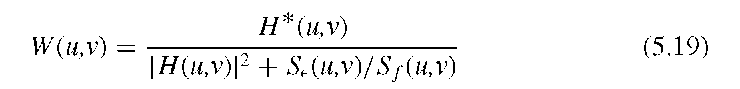

###The noise is cleaned using the Wiener filtering method. A gaussian kernel is created (default 3x3 filter) using normal random numbers. That kernel is passed into the Wiener filter method. The constant K is the ratio of Spectral Power Density of the noisy image and the Spectral Power Density of the filter kernel used. We pass it as 10 instead of calculating it manually in the code each time.

###Finally after the Fast Fourier Transform function is used, the output must be inverted using Inverse Fast Fourier Transform Function.

In [ ]:
# Blurring and de blurring
def blur(img, kernel_size = 3):
	dummy = np.copy(img)
	h = np.eye(kernel_size) / kernel_size
	dummy = convolve2d(dummy, h, mode = 'valid')
	return dummy

blur_imgs = np.zeros((10,391,870))

clean_blur = np.full_like(imgs,0)

for i in range(10):
  blur_imgs[i] = blur(imgs[i],10)

kernel = gaussian_kernel()

for i in range(10):
  clean_blur[i] = wiener_filter(imgs[i],kernel,K=10)

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[0],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[0],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[0],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[1],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[1],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[1],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[2],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[2],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[2],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[3],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[3],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[3],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[4],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[4],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[4],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[5],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[5],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[5],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[6],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[6],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[6],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[7],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[7],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[7],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[8],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[8],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[8],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[9],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(blur_imgs[9],cmap='gray')
plt.title('Motion blur image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(clean_blur[9],cmap='gray')
plt.title('De-blurred image')
plt.axis('off')

## Sharpening of Images

### Sharpening basically means to highlight transitions in intensity of a image. Sharpening filters are high pass spatial filters.

### Sharpening can be accomplised by spatial differentiation (i.e the rate of change of pixels intensities / colors in the spatial plane).

### Method 1  : Laplacian

#### The laplacian derivative (first degree) = Vf = df'/dx + df'/dy. <br>
Here, df'/dx = f(x + 1, y) - f(x, y), and df'/dy = f(x, y + 1) - f(x, y).

#### The laplacian derivative (second degree) = V^2f = d^2f'/dx^2 + d^2f'/dy^2. <br>
Here, df'/dx = f(x + 1, y) + f(x - 1, y) - 2f(x, y), and d^2f'/dy = f(x, y + 1) + f(x, y - 1) - 2f(x, y).

Used for removing blurring + enhancing (highlighting) the edges


In [ ]:
def laplacian_filter_4(images):
  
# As smoothing is achieved by smoothing in the neighbourhood, we can say that sharpening is done by
# spatial differentiation, where the strenght of the derivative operation is directly proportional to the magnitude of 
# intensity discontinuity at that point.
# Areas of edges (areas of high varying intensities) are emphasized while de emphasizes areas of slow varying intensities.

  laplacian_filter = []
  sharpened_images = []

  for image in images:
    # Image with padding for convineince (for use with a 3X3 filter).
    padded_image = image.copy()
    padded_image = cv2.copyMakeBorder(padded_image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
    img_width, img_height = padded_image.shape[0:2]

    # Sharpening using first derivative (i.e Laplacian), non rotated no diagonal consideration.
    # partial_derivative_on_x = f(x + 1, y) - f(x, y)
    # partial_derivative_on_x_2 = f(x + 1, y) + f(x - 1, y) - 2f(x, y)

    # partial_derivative_on_y = f(x, y + 1) - f(x, y)
    # partial_derivative_on_y_2 = f(x, y + 1) + f(x, y - 1) - 2f(x, y)

    # combining, laplacian = f(x + 1, y) + f(x - 1, y) + f(x, y + 1) + f(x, y -1) - 4f(x, y)
    # For convinience, as the center coeff is -ve, negating the full filter so it can be added directly with base / original image.

    # in filter form, we have for n4 : 
    laplacian_filter_4 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    laplacian_filtered_image_4 = cv2.filter2D(image, -1, laplacian_filter_4)
    laplacian_filter.append(laplacian_filtered_image_4)
    sharpened_image = cv2.addWeighted(image, 1, laplacian_filtered_image_4, 2, gamma=0)
    sharpened_images.append(sharpened_image)

  return laplacian_filter, sharpened_images

In [ ]:
def laplacian_filter_8(images):
  laplacian_filter = []
  sharpened_images = []

  for image in images:
    # Image with padding for convineince (for use with a 3X3 filter).
    padded_image = image.copy()
    padded_image = cv2.copyMakeBorder(padded_image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
    img_width, img_height = padded_image.shape[0:2]

    # Sharpening using second derivative (i.e Laplacian), with diagonal consideration.
    # For convinience, as the center coeff is -ve, negating the full filter so it can be added directly with base / original image.

    # in filter form, we have for n8 : 
    laplacian_filter_8 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    laplacian_filtered_image_8 = cv2.filter2D(image, -1, laplacian_filter_8)
    laplacian_filter.append(laplacian_filtered_image_8)

    sharpened_image_8 = cv2.addWeighted(image, 1, laplacian_filtered_image_8, 1.5, gamma=0)
    sharpened_images.append(sharpened_image_8)

  return laplacian_filter, sharpened_images


### Method 2. Unsharp masking method for sharpening (primarily used by publishing industry.)
### First, the image is to be blurred. Subtract said blurred image from the original. This becomes the 'mask'.
### Then, add the mask to hte original image.


In [ ]:
def unsharp_masking(images, blurred_images):
  unsharp_mask = [] * len(images)
  sharpened_images = [] * len(images)

  for i in range(0, len(images)):
    mask = cv2.addWeighted(images[i], 1, blurred_images[i], -1, gamma=0)
    sharpened_image = cv2.addWeighted(images[i], 1, mask, 3, gamma=0) 
    unsharp_mask.append(mask)
    sharpened_images.append(sharpened_image)

  return unsharp_mask, sharpened_images


## Method 3 : Sorbel edge detector (Approximation of Roberts Cross Gradient)
### Here, image is processed in the X and Y axis one after another. The new image is the sum of X and Y results (i.e the edges highlighted) of the image.
### Calculation is based on gradient of images intensity. Here, gradient = Vf = [df'/dx    df'/dy].
### This vector points in the direction of the greatest rate of change of intensity at some location(x, y). The magnitude of this vector is the value of
### rate of change in direction of said gradiant vector. Rather than finding magnitude via sqrt(Vf.x^2 + Vf.y^2), we can do : 
### mag(x, y) = |Vf.x| + |Vf.y|

### The x derivate is : [1, 0, -1] and the 1D gaussian filter is [1, 2, 1]. Here, the values (1, 2) are important as we give more importance to the center compared to the rest.
### The gaussian filter * x derivative = [[1, 0, -1], [2, 0, -2], [1, 0, -1]] (gx or sorbel x)
### Similarly, for y derivative we have [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

In [ ]:
def sorbel(images):
    sorbel_filter = []
    sharpened_images = []

    for image in images:
      # Image with padding for convineince (for use with a 3X3 filter).
      padded_image = image.copy()
      padded_image = cv2.copyMakeBorder(padded_image, 2, 2, 2, 2, cv2.BORDER_CONSTANT, None, 0)
      img_width, img_height = padded_image.shape[0:2]
 
      gx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
      sorbel_x_filtered = cv2.filter2D(image, -1, gx)

      gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
      sorbel_y_filtered = cv2.filter2D(image, -1, gy)

      sorbel_filtered = cv2.addWeighted(sorbel_x_filtered, 1, sorbel_y_filtered, 1, gamma=0)
      sorbel_filter.append(sorbel_filtered)
      sharpened_image = cv2.addWeighted(image, 1, sorbel_filtered, 2, gamma=0)
      sharpened_images.append(sharpened_image)

    return sorbel_filter, sharpened_images

In [ ]:
# Driver code for sharpening
imgs = imgs.copy()

org_images = [] 

# plt.imshow does not accept BGR, so converting images to RGB.
for i in range(0, len(imgs)):
  org_images.append(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))

imgs = org_images

# blur the images (using Gaussian blur)
gaussian_blurred_images = blur_images(imgs)

# laplacian filter and the sharpened image (n4)
laplacian_filter_n4, sharpened_images_laplacian_4 = laplacian_filter_4(imgs)

# laplacian filter and the sharpened image (n8)
laplacian_filter_n8, sharpened_images_laplacian_8 = laplacian_filter_8(imgs)

# Unsharp mask and sharpened images
unsharp_mask, sharpened_images_unsharp = unsharp_masking(imgs, gaussian_blurred_images)

# sorbel mask and sharpened_images
sorbel_filter, sharpened_images_sorbel = sorbel(imgs)

for i in range(len(imgs)):
  plt.figure(figsize=(100,9))
  
  plt.subplot(1,9,1)
  plt.imshow(imgs[i])
  plt.title('Original image')
  plt.axis('off')
  
  plt.subplot(1,9,2)
  plt.imshow(sharpened_images_laplacian_4[i])
  plt.title('Sharpened image laplacian n4')
  plt.axis('off')
  
  plt.subplot(1,9,3)
  plt.imshow(sharpened_images_laplacian_8[i])
  plt.title('Sharpened image laplacian n8')
  plt.axis('off')
  
  plt.subplot(1,9,4)
  plt.imshow(sharpened_images_unsharp[i])
  plt.title('Sharpened image unsharp masking')
  plt.axis('off')

  plt.subplot(1, 9, 5)
  plt.imshow(sharpened_images_sorbel[i])
  plt.title('Sharpened image using sorbel')
  plt.axis('off')

  plt.subplot(1,9,6)
  plt.imshow(laplacian_filter_n4[i])
  plt.title('Laplacian n4 filter')
  plt.axis('off')

  plt.subplot(1,9,7)
  plt.imshow(laplacian_filter_n8[i])
  plt.title('Laplacian n8 filter')
  plt.axis('off')

  plt.subplot(1,9,8)
  plt.imshow(unsharp_mask[i])
  plt.title('unsharp mask')
  plt.axis('off')

  plt.subplot(1,9,9)
  plt.imshow(sorbel_filter[i])
  plt.title('sorbel mask')
  plt.axis('off')

## Affine Transformations

#### Relavance to project : Camera calibration (i.e converting 3D point in world space to a 2D pixel) parameters include Rotation and Translation matrices, when going from world coordinates to camera coordinates.

In [ ]:
def translate(images):

  translated_images = []

  for i in range(len(images)):
    shape = images[i].shape

    # Using homogeneous coordinates to represent 2D point (x, y) as 3D point(x', y', z')
    # so that to go from 3D to 2D point we must do (x' / z', y' / z')

    # Translation.
    # Matrix requires so that (x, y, 1) -> (x + t2, y + t1, 1) is : 
    t1 = i * 10
    t2 = i * 10

    # Note, matrix is premultiplied (i.e lies on the left of vector, so vector is column vector here.)
    # It is negated here because the (x, y) of translated image = source_image(x + t2, y + t1), so for visual appeal negating t2 and t1 (will be changed in future)
    translation_matrix = np.array([[1, 0, -t2], [0, 1, -t1], [0, 0, 1]])

    image = images[i]
    
    translated_image = image.copy()
    for i in range(0, shape[0]):
      for j in range(0, shape[1]):
          homogeneous_coord = [i, j, 1]
          coord = translation_matrix.dot(homogeneous_coord)
          coord = coord[0:2]
          if coord[0] < 0 or coord[0] >= translated_image.shape[0] or coord[1] < 0 or coord[1] >= translated_image.shape[1]:
              translated_image[i, j, 0] = 0
              translated_image[i, j, 1] = 0
              translated_image[i, j, 2] = 0
              continue


          translated_image[i, j, 0] = image[int(coord[0]), int(coord[1]), 0]
          translated_image[i, j, 1] = image[int(coord[0]), int(coord[1]), 1]
          translated_image[i, j, 2] = image[int(coord[0]), int(coord[1]), 2]

    translated_images.append(translated_image)

  return translated_images

def rotate(images):
  rotated_images = [] * len(images)
  for i in range(len(images)):
    # Rotation around z axis by theta degree CCW
    theta = np.deg2rad(i * 2)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    image = images[i].copy()
    shape = image.shape

    rotated_image = image.copy()
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            homogeneous_coord = [i, j, 1]
            coord = rotation_matrix.dot(homogeneous_coord)
            coord = coord[0:2]
            if coord[0] < 0 or coord[0] >= shape[0] or coord[1] < 0 or coord[1] >= shape[1]:
                rotated_image[i, j, 0] = 0
                rotated_image[i, j, 1] = 0
                rotated_image[i, j, 2] = 0
                continue


            rotated_image[i, j, 0] = image[int(coord[0]), int(coord[1]), 0]
            rotated_image[i, j, 1] = image[int(coord[0]), int(coord[1]), 1]
            rotated_image[i, j, 2] = image[int(coord[0]), int(coord[1]), 2]


    rotated_images.append(rotated_image)

  return rotated_images

def scale(images):
  
  scaled_images = [] * len(images)

  for i in range(len(images)):
        # Scaling
    s1 = float(i + 0.1) / 6
    s2 = float(i + 0.1) / 6

    shape = images[i].shape
    image = images[i].copy()

    # Scaling matrix is required so it takes (x, y, 1) to (xs1, ys2, 1). Matrix for this is : 
    scaling_matrix = np.array([[s1, 0, 0], [0, s2, 0], [0, 0, 1]]) # Column vector required.

    scaled_image = image.copy()
    scaled_image = cv2.resize(scaled_image, (int(shape[1] * s1), int(shape[0] *  s2)))

    for i in range(0, shape[0]):
      for j in range(0, shape[1]):
          homogeneous_coord = [i, j, 1]
          coord = scaling_matrix.dot(homogeneous_coord)
          coord = coord[0:2]
          if coord[0] < 0 or coord[0] >= scaled_image.shape[0] or coord[1] < 0 or coord[1] >= scaled_image.shape[1]:
              continue


          scaled_image[int(coord[0]), int(coord[1]), 0] = image[i, j, 0]
          scaled_image[int(coord[0]), int(coord[1]), 1] = image[i, j, 1]
          scaled_image[int(coord[0]), int(coord[1]), 2] = image[i, j, 2]

    scaled_images.append(scaled_image)

  return scaled_images

In [ ]:
# Visualize affine transformations

imgs = imgs.copy()

scaled = scale(imgs)
for i in range(len(scaled)):
  print("scaled by : ", (i + 0.1) / 6,', ', (i + 0.1) / 6)
  cv2_imshow(scaled[i])

translated = translate(imgs)

for i in range(len(translated)):
  print("translated by : " ,i * 10 , ", " ,i * 10)
  cv2_imshow(translated[i])

rotated = rotate(imgs)
for i in range(len(translated)):
  print('rotated by : ', np.deg2rad(i * 2))
  cv2_imshow(rotated[i])

imgs = imgs.copy()



## Stereo Vision
Process of reconstructing 3D geometry based on images from multiple viewpoints (2 viewpoints in our application). Works very similar as human vision.

In [ ]:
exp = cv2.imread('images/DrivingStereo_dataset/Stereo/disparity_exp.png')
cv2_imshow(exp)

## Disparity map generation : Map of difference in location of all points from both camera angles (left and right).

In [ ]:
left = cv2.imread('images/DrivingStereo_dataset/Stereo/left.jpg', cv2.IMREAD_GRAYSCALE)
right = cv2.imread('images/DrivingStereo_dataset/Stereo/right.jpg'  ,cv2.IMREAD_GRAYSCALE)

left = cv2.resize(left,None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_LINEAR)
right  = cv2.resize(right,None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_LINEAR)

print("Left")
cv2_imshow(left)

print("Right")
cv2_imshow(right)

stereo = cv2.StereoBM_create(numDisparities=0, blockSize=21)
disparity_raw = stereo.compute(left, right)
print("Disparity Map")
cv2_imshow(disparity_raw)

In [ ]:
!git clone https://github.com/Shankar0x/DepthSensingDatasets.git images
from PIL import Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image
import scipy.ndimage as ndimage
from scipy.ndimage.filters import gaussian_filter
import math
import statistics
import glob
import random
#from google.colab.patches import cv2_imshow
from scipy import signal
from math import log10, sqrt
from skimage.util import random_noise

In [ ]:
a = np.asarray(Image.open('images/Reduced_dataset/000001/left.png'))
print("The shape of the images are: ",a.shape)

In [ ]:
path = 'images/Reduced_dataset/0000'
left_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/left.png').convert('L')
    else:
        image = Image.open(path+str(i)+'/left.png').convert('L')
    data = np.asarray(image)
    left_imgs[i-1] = data
left_imgs.shape

In [ ]:
path = 'images/Reduced_dataset/0000'
right_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/right.png').convert('L')
    else:
        image = Image.open(path+str(i)+'/right.png').convert('L')
    data = np.asarray(image)
    right_imgs[i-1] = data
right_imgs.shape

In [ ]:
path = 'images/Reduced_dataset/0000'
right_disp_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/right_disp.png')
    else:
        image = Image.open(path+str(i)+'/right_disp.png')
    data = np.asarray(image)
    right_disp_imgs[i-1] = data
right_disp_imgs.shape

In [ ]:
path = 'images/Reduced_dataset/0000'
left_disp_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/left_disp.png')
    else:
        image = Image.open(path+str(i)+'/left_disp.png')
    data = np.asarray(image)
    left_disp_imgs[i-1] = data
left_disp_imgs.shape

### Displaying left and right stereo images and their respective disparity maps

In [ ]:
fig, ax = plt.subplots(3,4,figsize=(12,8))

for i in range(3):
        ax[i,0].title.set_text('Left stereo image')
        ax[i,0].imshow(left_imgs[i], cmap='gray')
        ax[i,0].axis('off')
        ax[i,1].title.set_text('Left disparity map')
        ax[i,1].imshow(left_disp_imgs[i],cmap='gray')
        ax[i,1].axis('off')
        ax[i,2].title.set_text('Right stereo image')
        ax[i,2].imshow(right_imgs[i], cmap='gray')
        ax[i,2].axis('off')
        ax[i,3].title.set_text('Right disparity image')
        ax[i,3].imshow(right_disp_imgs[i],cmap='gray')
        ax[i,3].axis('off')

# Shankar's Part

### Unsharp masking and highboost filtering
<b> Unsharp masking </b>
<br>
<p> In unsharp masking, the blurred version of the image is taken as a mask which is then subtracted from the original image. This gives a clearer image as the inital blur is removed. </p>
<b> Highboost filtering </b>
<br>
<p> In image processing, it is often desirable to emphasize high frequency components representing the image details without eliminating low frequency components (such as sharpening). The high-boost filter can be used to enhance high frequency component. </p>

In [ ]:
def unsharp_highboost_filtering(k, img):
    f = img
    fig, ax = plt.subplots(3,3,figsize=(20,16))
    ax[0,0].title.set_text('Original Image')
    ax[0,0].imshow(f, cmap='gray')
    ax[0,0].axis('off')

    # input image in frequency domain, F(u,v)
    F = np.fft.fftshift(np.fft.fft2(f))

    ax[0,1].title.set_text('DFT centered')
    ax[0,1].imshow(np.log1p(np.abs(F)), cmap='gray')
    ax[0,1].axis('off')

    # Gaussian Low Pass Filter
    M,N = F.shape
    H = np.zeros((M,N), dtype=np.float32)
    D0 = 10
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = np.exp(-D**2/(2*D0*D0))

    ax[0,2].title.set_text('Gaussian Low Pass Filter')
    ax[0,2].imshow(H, cmap='gray')
    ax[0,2].axis('off')

    # create fLP(x,y) (smoothed image)
    FLP = H * F    
    FLP = np.fft.ifftshift(FLP)
    fLP = np.abs(np.fft.ifft2(FLP))

    ax[1,0].title.set_text('DFT of image after GLPF centered')
    ax[1,0].imshow(fLP, cmap='gray')
    ax[1,0].axis('off')

    # create mask g(x,y)
    gMask = f - fLP

    ax[1,1].title.set_text('Mask (image - blurred image)')
    ax[1,1].imshow(gMask, cmap='gray')
    ax[1,1].axis('off')

    # unsharp masking
    g = f + 1*gMask

    ax[1,2].title.set_text('Unsharp masking')
    ax[1,2].imshow(g, cmap='gray')
    ax[1,2].axis('off')

    g = np.clip(g, 0, 255)
    ax[2,0].title.set_text('Unsharp masking (clipped)')
    ax[2,0].imshow(g, cmap='gray')
    ax[2,0].axis('off')

    # Highboost filtering
    G = (1 + k*(1-H))*F
    g = np.abs(np.fft.ifft2(np.fft.ifftshift(G)))
    ax[2,1].title.set_text('Highboost filtering')
    ax[2,1].imshow(g, cmap='gray')
    ax[2,1].axis('off')

    g = np.clip(g, 0, 255)
    ax[2,2].title.set_text('Highboost filtering (clipped)')
    ax[2,2].imshow(g, cmap='gray')
    ax[2,2].axis('off')

In [ ]:
unsharp_highboost_filtering(2, left_imgs[0])

### Laplacian Filtering
<p> Laplacian filtering is a technique used to make edge detection easier

In [ ]:
def laplacian_filtering(img):
    f = img
    # normalizing the image
    f = f / 255

    fig, ax = plt.subplots(2,2,figsize=(22,16))
    ax[0,0].title.set_text('Original Image')
    ax[0,0].imshow(f,cmap='gray')
    ax[0,0].axis('off')

    # transform into frequency domain
    F = np.fft.fftshift(np.fft.fft2(f))

    plt.figure(dpi=150)
    ax[0,1].title.set_text('DFT of image (centered)')
    ax[0,1].imshow(np.log1p(np.abs(F)),cmap='gray')
    ax[0,1].axis('off')

    # Laplacian Filter
    P,Q = F.shape
    H = np.zeros((P,Q), dtype=np.float32)
    for u in range(P):
        for v in range(Q):
            H[u,v] = -4*np.pi*np.pi*((u-P/2)**2 + (v-Q/2)**2)

    # Laplacian image
    Lap = H * F
    Lap = np.fft.ifftshift(Lap)
    Lap = np.real(np.fft.ifft2(Lap))

    # convert the Laplacian Image value into range [-1,1]
    OldRange = np.max(Lap) - np.min(Lap)
    NewRange = 1 - -1
    LapScaled = (((Lap - np.min(Lap)) * NewRange) / OldRange) + -1

    ax[1,0].title.set_text('Laplacian of the image')
    ax[1,0].imshow(LapScaled,cmap='gray')
    ax[1,0].axis('off')

    # image ehancement
    c = -1
    g = f + c*LapScaled
    g = np.clip(g, 0, 1)

    ax[1,1].title.set_text('Laplacian Filtered')
    ax[1,1].imshow(g,cmap='gray')
    ax[1,1].axis('off')

In [ ]:
laplacian_filtering(left_imgs[0])

### Inducing periodic noise and removing using Band Reject filters

In [ ]:
def ideal_low_pass_filter(image, d0):
  m, n = image.shape
  
  H = np.zeros((m, n), dtype=np.float32)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2)**2 + (v - n / 2) ** 2)
      if d <= d0:
        # Inside the allowed - frequency range
        H[u, v] = 1
      else:
        H[u, v] = 0
  
  return H

In [ ]:
def periodic_noise(img):
    f = img
    F = np.fft.fftshift(np.fft.fft2(f))
    x = np.linspace(1,1080,1080)
    y = np.linspace(1, 860, 860)
    x_1, y_1 = np.meshgrid(x, y)
    mysinusoidal = 15*np.sin(2*np.pi/14*x_1+2*np.pi/14*y_1)
    noisy_img = left_imgs[0]+mysinusoidal
    return noisy_img

In [ ]:
def band_reject(img):

    f = img
    F = np.fft.fftshift(np.fft.fft2(f))
    
    fig, ax = plt.subplots(3,2,figsize=(26,34))

    ax[0,0].title.set_text('Original Image')
    ax[0,0].imshow(f,cmap='gray')
    ax[0,0].axis('off')

    ax[0,1].title.set_text('DFT of the image (centered)')
    ax[0,1].imshow(np.log1p(np.abs(F)), cmap='gray')
    ax[0,1].axis('off')

    noisy_img = periodic_noise(img)

    ax[1,0].title.set_text('Noisy image')
    ax[1,0].imshow(noisy_img, cmap='gray')
    ax[1,0].axis('off')

    F_new = np.fft.fftshift(np.fft.fft2(noisy_img))

    ax[1,1].title.set_text('DFT of noisy image')
    ax[1,1].imshow(np.log1p(np.abs(F_new)), cmap='gray')    
    ax[1,1].axis('off')

    H1 = ideal_low_pass_filter(left_imgs[0], 130)
    H2 = ideal_low_pass_filter(left_imgs[0], 90)
    H3 = H1 - H2
    H3 = 1 - H3

    cleaned_dft = F_new*H3 
    ax[2,1].title.set_text('DFT after band reject filter')
    ax[2,1].imshow(np.log1p(np.abs(cleaned_dft)),cmap='gray')
    ax[2,1].axis('off')

    ift_cleaned = np.fft.ifftshift(cleaned_dft)
    ift_cleaned = np.fft.ifft2(ift_cleaned)
    ax[2,0].title.set_text('Cleaned using Band Reject')
    ax[2,0].imshow((np.abs(ift_cleaned)),cmap='gray')
    ax[2,0].axis('off')
    
    

In [ ]:
band_reject(left_imgs[0]);

### Band pass filter
<p> Band pass filter is a type of high pass filter. The output of bandpass filter essentially contains the edges of the image. Adding this image on the original image will result in a sharper image.

In [ ]:
def bandpass(img):
    fig, ax = plt.subplots(1,4,figsize=(28,50))
    H1 = ideal_low_pass_filter(img, 300)
    H2 = ideal_low_pass_filter(img, 100)
    H3 = H1 - H2
    ax[3].title.set_text('Sharpened by band pass filtering')
    ax[3].imshow(img,cmap='gray') 
    ax[3].axis('off')

    ax[1].title.set_text('Band pass filter')
    ax[1].imshow(H3, cmap='gray')
    ax[1].axis('off')

    F_new = np.fft.fftshift(np.fft.fft2(img))
    inv_conv = F_new*H3 
    ift_cleaned = np.fft.ifftshift(inv_conv)
    ift_cleaned = np.fft.ifft2(ift_cleaned)

    ax[2].title.set_text('Band pass filtered image')
    ax[2].imshow((np.abs(ift_cleaned)),cmap='gray')
    ax[2].axis('off')

    test_img = img+np.abs(ift_cleaned)
    ax[0].title.set_text('Original image')
    ax[0].imshow(test_img,cmap='gray')  
    ax[0].axis('off')
    

In [ ]:
bandpass(left_imgs[0])

### Notch filtering
<p> This is a filtering technique used to remove periodic noise by adding notches on the DFT of the noisy image corresponding to the sinusoidal component.

In [ ]:
def notch_filtering(img):
    noisy_img = periodic_noise(img)
    bg = np.zeros_like(img)
    bg = bg + 255
    c1_cords = (img.shape[1]//2-78, img.shape[0]//2-70)
    c2_cords = (img.shape[0]//2+190, img.shape[1]//2-50)
    radius = 15
    color = (0,0,0)
    thickness = -1
    image1 = cv2.circle(bg, c1_cords, radius, color, thickness)
    image2 = cv2.circle(bg, c2_cords, radius, color, thickness)
    image = image1+image2
    
    F_orig = np.fft.fftshift(np.fft.fft2(img))

    F = np.fft.fftshift(np.fft.fft2(noisy_img))
    F_new = F*image 
    fig, ax = plt.subplots(3,2,figsize=(26,34))

    ax[0,0].title.set_text('Original image')
    ax[0,0].imshow(img,cmap='gray')
    ax[0,0].axis('off')

    ax[0,1].title.set_text('DFT of original image')
    ax[0,1].imshow(np.abs(np.log1p(F_orig)),cmap='gray')
    ax[0,1].axis('off')

    ax[1,0].title.set_text('Periodic noisy image')
    ax[1,0].imshow(noisy_img,cmap='gray')
    ax[1,0].axis('off')

    ax[1,1].title.set_text('DFT of periodic image')
    ax[1,1].imshow(np.abs(np.log1p(F)),cmap='gray')
    ax[1,1].axis('off')

    ift_cleaned = np.fft.ifftshift(F_new)
    ift_cleaned = np.fft.ifft2(ift_cleaned)

    ax[2,0].title.set_text('Notch filtered image')
    ax[2,0].imshow(np.abs(ift_cleaned),cmap='gray')
    ax[2,0].axis('off')

    ax[2,1].title.set_text('DFT of notch filtered image')
    ax[2,1].imshow(np.abs(np.log1p(F_new)),cmap='gray')
    ax[2,1].axis('off')

In [ ]:
notch_filtering(left_imgs[0])

# Sneha's Part

In [ ]:
def pxIsInImgRange(x, y, w, h):
  if (0<=x) and (x < w): 
    if (0<=y) and (y < h):
      return True
  return False

In [ ]:
def minfilter(img,radius):
  h = img.shape[0]
  w = img.shape[1]
  img2 = np.zeros_like(img)
  for x in range (-radius, w+radius):
      for y in range (-radius, h+radius):
          if pxIsInImgRange(x,y,w,h): 
                  px = []
                  for vx2 in range (-radius, radius+1):
                      for vy2 in range (-radius, radius+1):
                          x2 = x + vx2
                          y2 = y + vy2
                          if pxIsInImgRange(x2,y2, w, h):
                              px.append(img[y2][x2])

                  minimum = min(px)
                  img2[y][x] = minimum

  return img2

In [ ]:
def maxfilter(img,radius):
  h = img.shape[0]
  w = img.shape[1]
  img2 = np.zeros_like(img)
  for x in range (-radius, w+radius):
      for y in range (-radius, h+radius):
          if pxIsInImgRange(x,y,w,h): 
                  px = []
                  for vx2 in range (-radius, radius+1):
                      for vy2 in range (-radius, radius+1):
                          x2 = x + vx2
                          y2 = y + vy2
                          if pxIsInImgRange(x2,y2,w,h):
                              px.append(img[y2][x2])

                  maximum = max(px)
                  img2[y][x] = maximum

  return img2

In [ ]:
def medianfilter(img,radius):
  h = img.shape[0]
  w = img.shape[1]
  img2 = np.zeros_like(img)
  for x in range (-radius, w+radius):
      for y in range (-radius, h+radius):
          if pxIsInImgRange(x,y,w,h): 
                  px = []
                  for vx2 in range (-radius, radius+1):
                      for vy2 in range (-radius, radius+1):
                          x2 = x + vx2
                          y2 = y + vy2
                          if pxIsInImgRange(x2,y2,w,h):
                              px.append(img[y2][x2])
                  median = statistics.median(px)
                  img2[y][x] = median

  return img2

In [ ]:
def mdptfilter(img,radius):
  h = img.shape[0]
  w = img.shape[1]
  img2 = np.zeros_like(img)
  for x in range (-radius, w+radius):
      for y in range (-radius, h+radius):
          if pxIsInImgRange(x,y,w,h): 
                  px = []
                  for vx2 in range (-radius, radius+1):
                      for vy2 in range (-radius, radius+1):
                          x2 = x + vx2
                          y2 = y + vy2
                          if pxIsInImgRange(x2,y2,w,h):
                              px.append(img[y2][x2])

                  px.sort()
                  maxi = max(px)
                  mini = min(px)
                  mdpt = int((int(mini)+int(maxi))/2)
                  img2[y][x] = mdpt
  return img2

In [ ]:
def noise_gen(img,typeofnoise):
    row, col = img.shape
    if typeofnoise == 'Gaussian':
        gauss = np.random.normal(10,10,(row,col))
        noisy = img + gauss
    elif typeofnoise == 'SnP':
        noise = np.zeros((row,col),dtype = np.float32)
        pepper = 0.05
        salt = 1-pepper
        for i in range(row):
            for j in range(col):
                rdn = np.random.random()
                if rdn < pepper:
                    noise[i][j]=0
                elif rdn>salt:
                    noise[i][j]=255
                else:
                    noise[i][j]=img[i][j]
        noisy = img + noise
    elif typeofnoise == 'Uniform':
        noise = np.zeros((row,col),dtype = np.float32)
        for i in range(row):
            for j in range(col):
                noise[i][j]= np.random.uniform(0,500)
        noisy = img + noise
    elif typeofnoise == 'Salt':
        noise = np.zeros((row,col),dtype = np.float32)
        salt = 0.6
        for i in range(row):
            for j in range(col):
                rdn = np.random.random()
                if rdn>salt:
                    noise[i][j]=255
                else:
                    noise[i][j]=img[i][j]
        noisy = img + noise
    elif typeofnoise == 'Pepper':
        noise = np.zeros((row,col),dtype = np.float32)
        pepper = 0.6
        for i in range(row):
            for j in range(col):
                rdn = np.random.random()
                if rdn < pepper:
                    noise[i][j]=0
                else:
                    noise[i][j]=img[i][j]
        noisy = img + noise
    return noisy

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(16,9))
img = left_imgs[7]

kernel = 3
radius = int((kernel-1)/2)

ax[0,0].title.set_text('Original Image')
ax[0,0].imshow(img,cmap='gray')
ax[0,0].axis('off')

ax[0,1].title.set_text('Gaussian Noise')
ax[0,1].imshow(noise_gen(img, 'Gaussian'),cmap='gray')
ax[0,1].axis('off')

ax[0,2].title.set_text('Midpoint filtering')
ax[0,2].imshow(mdptfilter(img,radius),cmap='gray')
ax[0,2].axis('off')

ax[1,0].title.set_text('Original Image')
ax[1,0].imshow(img,cmap='gray')
ax[1,0].axis('off')

ax[1,1].title.set_text('Uniform Noise')
ax[1,1].imshow(noise_gen(img, 'Uniform'),cmap='gray')
ax[1,1].axis('off')

ax[1,2].title.set_text('Midpoint Filtering')
ax[1,2].imshow(mdptfilter(img,radius),cmap='gray')
ax[1,2].axis('off')


In [ ]:
fig, ax = plt.subplots(2,3,figsize=(16,9))
img = left_imgs[17]

kernel = 3
radius = int((kernel-1)/2)

ax[0,0].title.set_text('Original Image')
ax[0,0].imshow(img,cmap='gray')
ax[0,0].axis('off')

ax[0,1].title.set_text('Salt Noise')
ax[0,1].imshow(noise_gen(img, 'Salt'),cmap='gray')
ax[0,1].axis('off')

ax[0,2].title.set_text('Min filtering')
ax[0,2].imshow(minfilter(img,radius),cmap='gray')
ax[0,2].axis('off')

ax[1,0].title.set_text('Original Image')
ax[1,0].imshow(img,cmap='gray')
ax[1,0].axis('off')

ax[1,1].title.set_text('Pepper Noise')
ax[1,1].imshow(noise_gen(img, 'Pepper'),cmap='gray')
ax[1,1].axis('off')

ax[1,2].title.set_text('Max Filtering')
ax[1,2].imshow(maxfilter(img,radius),cmap='gray')
ax[1,2].axis('off')


In [ ]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
img = left_imgs[8]

kernel = 3
radius = int((kernel-1)/2)

ax[0].title.set_text('Original Image')
ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].title.set_text('Salt and pepper noise')
ax[1].imshow(noise_gen(img, 'SnP'),cmap='gray')
ax[1].axis('off')

ax[2].title.set_text('Median filtering')
ax[2].imshow(minfilter(img,radius),cmap='gray')
ax[2].axis('off')


In [ ]:
def gauss_PDF(img):
    row, col = img.shape
    gauss = np.random.normal(10,10,(row,col))
    noisy = img + gauss
    smooth_part = noisy[:15, :15]

    fig, ax = plt.subplots(2,2,figsize=(16,22))

    ax[0,0].title.set_text('Noisy Image')
    ax[0,0].imshow(noisy,cmap = 'gray')
    ax[0,0].axis('off')

    ax[0,1].title.set_text('Smooth Part')
    ax[0,1].imshow(smooth_part,cmap = 'gray')
    ax[0,1].axis('off')

    ax[1,0].title.set_text('Noisy Image Histogram')
    ax[1,0].hist(noisy.ravel(),256,[0,256])
    ax[1,0].axis('off')

    ax[1,1].title.set_text('Estimated Noise Distribution')
    ax[1,1].hist(smooth_part.ravel(),256,[0,256])
    ax[1,1].axis('off')


In [ ]:
gauss_PDF(left_imgs[10])

In [ ]:
def uniform_PDF(img):
    row, col = img.shape
    noise = np.zeros((row,col),dtype = np.float32)
    for i in range(row):
        for j in range(col):
            noise[i][j]= np.random.uniform(0,500)
    noisy = img + noise
    smooth_part = noisy[:15, :15]

    fig, ax = plt.subplots(2,2,figsize=(16,22))

    ax[0,0].title.set_text('Noisy Image')
    ax[0,0].imshow(noisy,cmap = 'gray')
    ax[0,0].axis('off')

    ax[0,1].title.set_text('Smooth Part')
    ax[0,1].imshow(smooth_part,cmap = 'gray')
    ax[0,1].axis('off')

    ax[1,0].title.set_text('Noisy Image Histogram')
    ax[1,0].hist(noisy.ravel(),256,[0,256])
    ax[1,0].axis('off')

    ax[1,1].title.set_text('Estimated Noise Distribution')
    ax[1,1].hist(smooth_part.ravel(),256,[0,256])
    ax[1,1].axis('off')


In [ ]:
uniform_PDF(left_imgs[13])

In [ ]:
def saltandpepper_PDF(img):
    row, col = img.shape
    noise = np.zeros((row,col),dtype = np.float32)
    pepper = 0.05
    salt = 1-pepper
    for i in range(row):
        for j in range(col):
            rdn = np.random.random()
            if rdn < pepper:
                noise[i][j]=0
            elif rdn>salt:
                noise[i][j]=1
            else:
                noise[i][j]=img[i][j]
    noisy = img + noise
    smooth_part = noisy[:15, :15]

    fig, ax = plt.subplots(2,2,figsize=(16,22))

    ax[0,0].title.set_text('Noisy Image')
    ax[0,0].imshow(noisy,cmap = 'gray')
    ax[0,0].axis('off')

    ax[0,1].title.set_text('Smooth Part')
    ax[0,1].imshow(smooth_part,cmap = 'gray')
    ax[0,1].axis('off')

    ax[1,0].title.set_text('Noisy Image Histogram')
    ax[1,0].hist(noisy.ravel(),256,[0,256])
    ax[1,0].axis('off')

    ax[1,1].title.set_text('Estimated Noise Distribution')
    ax[1,1].hist(smooth_part.ravel(),256,[0,256])
    ax[1,1].axis('off')


In [ ]:
saltandpepper_PDF(left_imgs[22])

## Tarun's Part

In [ ]:
def fourier_transform(image):
  ft = np.fft.fft2(image)
  ft = np.fft.fftshift(ft)

  return ft

In [ ]:
img = left_imgs[4]

fig, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].title.set_text("Original image")
ax[0].imshow(img, cmap='gray')
ax[0].axis('off')

ft_image = fourier_transform(img)
enhanced_ft_image = np.log1p(np.abs(ft_image))
ax[1].title.set_text("Shifted fourier transform of image")
ax[1].imshow(enhanced_ft_image, cmap='gray')
ax[1].axis('off')

Ideal Low Pass Filter

A frequency domain low pass filter satisfiying the property : 
H(u, v) = {1 if D(u, v) >= D0, 0 if D(U, v) < D0) \
Here, D(u, v) is given by sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2) \
D0 is the cutoff frequency of the image (or the radius of the circle encompassing the low frequency componenets of frequency domain image). \
Blurs image, but produces significant blurring.

In [ ]:
img_shape = img.shape

def ideal_low_pass_filter(image, d0):
  m, n = image.shape
  
  H = np.zeros((m, n), dtype=np.float32)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2)**2 + (v - n / 2) ** 2)
      if d <= d0:
        # Inside the allowed - frequency range
        H[u, v] = 1
      else:
        H[u, v] = 0
  
  return H

Ideal High Pass Filter

A frequency domain filter given by 1 - Ideal Low Pass Filter \

That is, H(u, v) = {0 if D(u, v) >= D0, 1 if D(u, v) < D0} \
Here, D0 is the cutoff frequency, or the frequencies we wish to attenutate.

In [ ]:
def ideal_high_pass_filter(image, d0):
  m, n = image.shape

  H = np.zeros((m, n), dtype=np.float32)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2)**2 + (v - n / 2) ** 2)
      if d <= d0:
        # Inside not  allowed - frequency range
        H[u, v] = 0
      else:
        H[u, v] = 1
  
  return H

Visualizing the Ideal Low Pass Filter and Ideal High Pass Filter

In [ ]:
ilp_filters = []
for i in range(1, 10):
  ilp_filters.append(ideal_low_pass_filter(img, i * 10))

ihp_filters = []
for i in range(1, 10):
  ihp_filters.append(ideal_high_pass_filter(img, i * 10))

plt.figure(figsize=(30,5))

for i in range(1, 9):
  plt.subplot(1,10, i)
  plt.imshow(ilp_filters[i],cmap='gray')
  plt.title(('ILP D0->' + str(i * 10)))
  plt.axis('off')

plt.show()

plt.figure(figsize=(30,5))

for i in range(1, 9):
  plt.subplot(2,10, i)
  plt.imshow(ihp_filters[i],cmap='gray')
  plt.title(('IHP D0->' + str(i * 10)))
  plt.axis('on')


plt.show()

Applying the low pass & high pass ideal pass filters : Multiply frequency domain of image by the filter, and de - center (i.e shift it), and perform inverse fourier transform of the image.

In [ ]:
# Assume iamge is in spatial domain
def apply_low_pass_filter(ilp_filter, image):
  ft = np.fft.fft2(image)
  ft_shifted = np.fft.fftshift(ft)

  g = ft_shifted * ilp_filter

  g_spatial = np.fft.ifftshift(g)
  g_spatial = np.fft.ifft2(g_spatial)

  return g, g_spatial

In [ ]:
ilpf, ilp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_low_pass_filter(ilp_filters[i], img)
  ilpf.append(g)
  ilp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(ilpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow(np.log1p(np.abs(ilp_applied[i])),cmap='gray')
  plt.title('Spatial domain result')
  plt.axis('on')

plt.show()

In [ ]:
# Assume image is in spatial domain
def apply_high_pass_filter(ihp_filter, image):
  ft = np.fft.fft2(image)
  ft_shifted = np.fft.fftshift(ft)

  g = ft_shifted * ihp_filter

  g_spatial = np.fft.ifftshift(g)
  g_spatial = np.fft.ifft2(g_spatial)

  return g, g_spatial

In [ ]:
ihpf, ihp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_high_pass_filter(ihp_filters[i], img)
  ihpf.append(g)
  ihp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(ihpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow((np.abs(ihp_applied[i])),cmap='gray')
  plt.title('Ihpf mask ')
  plt.axis('on')

  
  plt.subplot(1,9,3)

  plt.imshow((np.abs(ihp_applied[i])) + img,cmap='gray')
  plt.title('Ihpf applied')
  plt.axis('on')

plt.show()

Why the ringing affect ? 

To visualize this, going from frequency -> spatial domain (just for the filters)

In [ ]:
white_image = np.ones((img.shape[0], img.shape[1]), dtype=np.float32)


ilpf, ilp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_low_pass_filter(ilp_filters[i], white_image)
  ihpf.append(g)
  ihp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(ilp_filters[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  ilp_ift = np.fft.ifftshift(ilp_filters[8-i])
  spatial_ilp = np.fft.fftshift(np.abs(np.fft.ifft2(ilp_ift)))
  plt.imshow((np.log1p(np.abs(spatial_ilp[100:-100,300:-300]))), cmap='gray')

  plt.title('Spatial ILP')
  plt.axis('on')



plt.show()

In [ ]:
white_image = np.ones((img.shape[0], img.shape[1]), dtype=np.float32)


ihpf, ihp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_high_pass_filter(ihp_filters[i], white_image)
  ihpf.append(g)
  ihp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(ihp_filters[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  ilp_ift = np.fft.ifftshift(ilp_filters[8-i])
  spatial_ilp = np.fft.fftshift(np.abs(np.fft.ifft2(ilp_ift)))
  plt.imshow((np.log1p(1.0 - np.abs(spatial_ilp[100:-100,300:-300]))), cmap='gray')

  plt.title('Spatial IHP')
  plt.axis('on')



plt.show()

# The Butterworth Low Pass Filter

A frequency domain given by :
H(u, v) = 1 / (1 + (D / D0) ^ 2n) \
Where, \
D = sqrt((u - m / 2) ** 2 + (v - n / 2) ** 2) \
D0 = cut off frequency \
n = order of filter 

In [ ]:
def butter_worth_low_pass(image, d0, order):
  m, n = image.shape
  H = np.zeros((m, n), dtype=np.float64)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2) ** 2 + (v - n / 2) ** 2)
      H[u, v] = 1 / (1 + (d/d0) ** (2 * order))

  return H

def butter_worth_high_pass(image, d0, order):
  m, n = image.shape
  H = np.zeros((m, n), dtype=np.float64)
  for u in range(m):
    for v in range(n):
      d = np.sqrt((u - m / 2) ** 2 + (v - n / 2) ** 2)
      H[u, v] = 1 / (1 + (d0/d) ** (2 * order))

  return H

In [ ]:
butter_worth_low_pass_filters = []
for i in range(1, 10):
  butter_worth_low_pass_filters.append(butter_worth_low_pass(img, i * 10, 2 ** (i/2)))

butter_worth_high_pass_filters = []
for i in range(1, 10):
  butter_worth_high_pass_filters.append(butter_worth_high_pass(img, i * 10, 2 ** (i / 2)))


plt.figure(figsize=(200,5))

for i in range(1, 9):
  plt.subplot(1,10, i)
  plt.imshow(butter_worth_low_pass_filters[i],cmap='gray')
  plt.title(('Butter low pass (D0, n) ' + str(i * 10) + '|' + str(2 ** (i/2))))
  plt.figure(figsize=(200,5))

  plt.axis('off')

plt.show()

plt.figure(figsize=(200,5))

for i in range(1, 9):
  plt.subplot(2,10, i)
  plt.imshow(butter_worth_high_pass_filters[i],cmap='gray')
  plt.title(('Butter worth high pass (D0, n) ' + str(i * 10) + '|' + str(2 ** (i/2))))
  plt.axis('on')
  plt.figure(figsize=(200,5))

plt.show()

Applying the butter worth high and low pass filters

In [ ]:
# Assume image is in spatial domain
def apply_butter_worth_pass_filter(filter, image):
  ft = np.fft.fft2(image)
  ft_shifted = np.fft.fftshift(ft)

  g = ft_shifted * filter

  g_spatial = np.fft.ifftshift(g)
  g_spatial = np.fft.ifft2(g_spatial)

  return g, g_spatial

Visualize the butter worth filters

In [ ]:
blpf, blp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_butter_worth_pass_filter(butter_worth_low_pass_filters[i], img)
  blpf.append(g)
  blp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(blpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow(np.log1p(np.abs(blp_applied[i])),cmap='gray')
  plt.title('Spatial domain result' + str('(D0, n) ') + str(i * 10) + '|' + str(2 ** (i/2)))

  plt.axis('on')

plt.show()

In [ ]:
butter_worth_low_pass_filters.append(butter_worth_low_pass(img, 50, 1000))

g, g_spatial = apply_butter_worth_pass_filter(butter_worth_low_pass_filters[-1], img)

plt.figure(figsize=(100,5))

plt.subplot(1,9, 1)
plt.imshow(np.log1p(np.abs(g)),cmap='gray')
plt.title('Convolution in FT')
plt.axis('off')

plt.subplot(1,9,2)

plt.imshow(np.log1p(np.abs(g_spatial)),cmap='gray')
plt.title('Spatial domain result' + str('(D0, n) ') + str(50) + '|' + str(1000))
plt.axis('on')


In [ ]:
bhpf, bhp_applied = [], []
for i in range(0,9):
  g, g_spatial = apply_butter_worth_pass_filter(butter_worth_high_pass_filters[i], img)
  bhpf.append(g)
  bhp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 8):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(bhpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow((np.abs(bhp_applied[i])),cmap='gray')
  plt.title('Spatial domain result' + str('(D0, n) ') + str(i * 10) + '|' + str(2 ** (i/2)))
  plt.axis('on')

  plt.subplot(1,9,3)

  plt.imshow((np.abs(bhp_applied[i])) + img,cmap='gray')
  plt.title('Butter worth applied')
  plt.axis('on')


plt.show()

Homomorphic Filtering \

Image enhancement technique (in frequency domain). \
Involves non linear mapping to different domain in which linear filtering techniques are applied. \
Then, it is followed by mapping back to the original domain. \
Simultaneously normalizes brightness, and increases contrast of image. \
Correct non uniform illumination in images & improving appearance (subjective) of gray scale image.

Illumination Reflectance Model : I(x, y) = L(x, y) * R(x, y) \
reflactance is associated with object edges and varies rapidly in space. \
illumination contributes to the dynamic range and various much slower compared to reflectance.


I(x, y) = ln() -> DFT -> H(u  v) -> DFT^-1, EXP -> G(x, y)

Demo : Homomorphic filtering with butter worth high pass filter

In [ ]:
# h is the filter we want to apply.
def homomorphic_filter(img, h):
  # Step 1 -> Natural log of image (to separate illumination and reflectance from image).
  image_nl = np.log1p(img)

  # Step 2 -> Transform image to the fourier domain.
  dft = np.fft.fftshift(np.fft.fft2(image_nl))

  # Step 3 -> Apply filter to DFT
  filtered_image = (dft *  h)

  # Step 4 -> Back to spatial domain
  spatial_img = np.real(np.fft.ifft2(np.fft.ifftshift(filtered_image)))

  # Step 5 -> Apply exponential to cancel affect of log.
  homomorphic_img = np.expm1(spatial_img, dtype=np.float64)

  # Step 6 -> Normalization
  img_homomorphic = cv2.normalize(homomorphic_img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  
  return homomorphic_img

In [ ]:
rainy_image = right_imgs[12]
rainy_image = cv2.normalize(rainy_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.xlabel('Original image')
plt.imshow(rainy_image, cmap='gray')
plt.plot()
plt.show()
img_height, img_width = rainy_image.shape[:2]

butter_worth_high_pass_filters = []
for i in range(1, 3):
  butter_worth_high_pass_filters.append(butter_worth_high_pass(rainy_image, i * 10, 2 ** (i+1)))

blpf, blp_applied = [], []
for i in range(0,2):
  g, g_spatial = apply_butter_worth_pass_filter(butter_worth_high_pass_filters[i], rainy_image)
  blpf.append(g)
  blp_applied.append(g_spatial)

plt.figure(figsize=(30,5))

for i in range(0, 2):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  plt.imshow(np.log1p(np.abs(blpf[i])),cmap='gray')
  plt.title('Convolution in FT')
  plt.axis('off')

  plt.subplot(1,9,2)

  plt.imshow(np.log1p(np.abs(blp_applied[i])),cmap='gray')
  plt.title('Spatial domain butter worth result' + str('(D0, n) ') + str(i * 10) + '|' + str(2 ** (i/2)))
  plt.axis('on')

  plt.subplot(1,9,3)

  homomorphic_image = homomorphic_filter(rainy_image, butter_worth_high_pass_filters[i])
  plt.imshow(((homomorphic_image)),cmap='gray')
  plt.title('Spatial domain butter worth + homomorphic' + str('(D0, n) ') + str(i * 10) + '|' + str(2 ** (i/2)))
  plt.axis('on')
  

plt.show()

Morphological Transformations

Broad set of image processing operations that processes binary images based on SE (Structuring elements) which dictates the nature of the operation.

Each pixel in image is adjusted based on value of pixels in its neighbourhood.

It is not subjective. Used for getting the ground truth of the description of region shapes, boundaries, and for extracting the various componenets from the image.

Erosion

Pixel will be considered 255 or 0 only if ALL pixels under the kernel is 255 or 0. OTherwise it is eroded (i.e color changes to 0 or 255)\

Mathematically, \
If A is the set and B is the kernel / structural element, then, the erosion of A by B is denoted by A (-) B, where 🇰
A (-) B = {z | (B)z is contained in A}. \
For the SE to erode the image at any point, the ENTIRE strucuting element must be contained by the binary image at said point. \

It shrinks or thins objects in a given binary image, as it removes pixels on object boundaries. Enlarges foreground holes, remove irrelavant small details from the image.

Useful for removing isolated pixels, removes outer layer of objects.

In [ ]:
def erode(image, se):
  # Create the padded image.
  # Image with padding for convineince (for use with a 3X3 filter).
  padded_image = image.copy()

  padded_image = cv2.copyMakeBorder(padded_image, 3, 3, 3, 3, cv2.BORDER_CONSTANT, None, 0)
  img_height, img_width = padded_image.shape[0:2]

  res = padded_image.copy()
  def map_se_255(x):
    if x == 1:
      return 255
    else:
      return 0

  for v in range(img_height-se.shape[0]):
    for u in range(img_width-se.shape[1]):
      covering = True
      for i in range(se.shape[0]):
        for j in range(se.shape[1]):
          if res[v+i, u+j] != map_se_255(se[i, j]):
            covering = False

      if covering:
        for i in range(se.shape[0]):
          for j in range(se.shape[1]):
            res[v+i, u+j] = 1
      
      else:
        for i in range(se.shape[0]):
          for j in range(se.shape[1]):
            res[v+i, u+j] = 0
      
  
  return res

In [ ]:
img = right_imgs[8]
noised_img = img

for x in range(noised_img.shape[0]):
  for y in range(noised_img.shape[1]):
    t = np.random.randint(0,20)
    if t == 3:
      noised_img[x, y] = 255

plt.imshow(noised_img, cmap = 'gray') 

binary_image = noised_img

se = np.ones((3, 3), dtype=np.uint8)
print("The structuring element used.")
print(se)


plt.figure(figsize=(30,5))

for i in range(0, 20):
  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  erosion = cv2.erode(binary_image, se, iterations=i+1)
  plt.imshow(erosion,cmap='gray')
  plt.title('Erosion iterations : ' + str(i + 1))
  plt.axis('off')

  plt.subplot(1,9, 2)
  erosion = 255 - cv2.erode(binary_image, se, iterations=i+1)
  plt.imshow(erosion,cmap='gray')
  plt.title('Erosion iterations : ' + str(i + 1))
  plt.axis('off')
plt.show()

Dilation in image processing \

Used for 'expanding an element A by some structural element B'. Adds pixels to object boundaries.
Even if a single pixel of the iamge is covered by the structural element, we set the entire area covered by teh structural element to 1, else 0.

In [ ]:

#ret, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img = left_imgs[9]
img = cv2.resize(img, (300,300))
noised_img = img

for x in range(noised_img.shape[0]):
  for y in range(noised_img.shape[1]):
    t = np.random.randint(0,30)
    if t == 3:
      noised_img[x, y] = 0

plt.imshow(noised_img) 

binary_image = noised_img

print("Opening image")
plt.imshow(img, cmap='gray')

plt.figure(figsize=(90,5))

for i in range(0, 18):

  plt.figure(figsize=(90,5))

  plt.subplot(1,9, 1)
  dilation = cv2.dilate(binary_image, se, iterations=i+1)
  plt.imshow(dilation,cmap='gray')
  plt.title('Dilation iterations : ' + str(i + 1))
  plt.axis('off')

  plt.subplot(1,9, 2)
  dilation = 255 - cv2.dilate(binary_image, se, iterations=i+1)
  plt.imshow(dilation,cmap='gray')
  plt.title('dilation iterations : ' + str(i + 1))
  plt.axis('off')

  plt.axis('on')

  plt.show()

plt.show()

Opening and Closing

Closing -> Erosion followed by Dilation.\
Opening -> Dilation folled by Erosion. \

Same properties for erosion and dilation, but the object size REMAINS THE SAME.

In [ ]:

#ret, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img = left_imgs[10]
noised_img = img
for x in range(noised_img.shape[0]):
  for y in range(noised_img.shape[1]):
    t = np.random.randint(0,10)
    if t == 3:
      noised_img[x, y] = 255

binary_image = noised_img
plt.imshow(binary_image,cmap='gray')
plt.figure(figsize=(30,5))

for i in range(0, 18):
  plt.figure(figsize=(100,5))

  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  erosion = cv2.erode(binary_image, se, iterations=i+1)
  dilation = cv2.dilate(erosion, se, iterations=i+1)
  plt.imshow(dilation,cmap='gray')
  plt.title('Closing iterations : ' + str(i + 1))
  plt.axis('off')

  plt.subplot(1,9, 2)
  dilation = 255 - cv2.dilate(dilation, se, iterations=i+1)
  plt.imshow(dilation,cmap='gray')
  plt.title('Closing iterations : ' + str(i + 1))
  plt.axis('off')

  plt.axis('on')

plt.show()

In [ ]:

#ret, binary_image = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img = right_imgs[20]
binary_image = img

plt.figure(figsize=(30,5))

for i in range(0, 18):
  plt.figure(figsize=(100,5))

  plt.figure(figsize=(100,5))

  plt.subplot(1,9, 1)
  dilation = cv2.dilate(binary_image, se, iterations=i+1)
  erosion = cv2.erode(dilation, se, iterations=i+1)
  plt.imshow(dilation,cmap='gray')
  plt.title('Opening iterations : ' + str(i + 1))
  plt.axis('off')

  plt.subplot(1,9, 2)
  dilation = 255 - erosion
  plt.imshow(dilation,cmap='gray')
  plt.title('Opening iterations : ' + str(i + 1))
  plt.axis('off')

  plt.axis('on')

plt.show()

## Ashfaq's Part

In [ ]:
left_images=left_imgs[:4]

# def dft(x):
#     x = np.asarray(x, dtype=float)
#     N = x.shape[0]
#     n = np.arange(N)
#     k = n.reshape((N, 1))
#     M = np.exp(-2j * np.pi * k * n / N)
#     return np.dot(M, x)
for f in left_images:
  # my_dft=dft(f)
  # print(my_dft)
  # print(my_dft.shape)
  # p,q=my_dft.shape
  dft = cv2.dft(np.float32(f),flags = cv2.DFT_COMPLEX_OUTPUT)

  # shift zero-frequency component to the center of the spectrum
  dft_shift = np.fft.fftshift(dft)
  magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],
        dft_shift[:,:,1])
    )
  dft_spectrum = 20*np.log(cv2.magnitude(dft[:,:,0],
        dft[:,:,1])
    )

  # visualize input image and the magnitude spectrum
  # plt.subplot(131),plt.imshow(f, cmap = 'gray')
  # plt.title('Input Image'), plt.xticks([]), plt.yticks([])
  # plt.subplot(132),plt.imshow(magnitude_spectrum, cmap = 'gray')
  # plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
  # plt.subplot(133),plt.imshow(dft_spectrum, cmap = 'gray')
  # plt.title('DFT Spectrum'), plt.xticks([]), plt.yticks([])

  plt.figure(figsize=(10,10))
  plt.title('Input Image')
  plt.imshow(f, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Fourier Transform')
  plt.imshow(dft_spectrum, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Fourier Transforming after centering')
  plt.imshow(magnitude_spectrum, cmap='gray')
  plt.axis('off')
  plt.show()
  # cv2_imshow(my_dft)

In [ ]:
import matplotlib.pyplot as plt

for f in left_images:
  dft = cv2.dft(np.float32(f),flags = cv2.DFT_COMPLEX_OUTPUT)
  F = np.fft.fft2(f)
  Fshift = np.fft.fftshift(F)
  # shift zero-frequency component to the center of the spectrum
  dft_shift = np.fft.fftshift(dft)
  magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],
        dft_shift[:,:,1])
    )
  dft_spectrum = 20*np.log(cv2.magnitude(dft[:,:,0],
        dft[:,:,1])
    )

  # visualize input image and the magnitude spectrum
  # plt.subplot(131),plt.imshow(f, cmap = 'gray')
  # plt.title('Input Image'), plt.xticks([]), plt.yticks([])
  # plt.subplot(132),plt.imshow(magnitude_spectrum, cmap = 'gray')
  # plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
  # plt.subplot(133),plt.imshow(dft_spectrum, cmap = 'gray')
  # plt.title('DFT Spectrum'), plt.xticks([]), plt.yticks([])

  plt.figure(figsize=(10,10))
  plt.title('Input Image')
  plt.imshow(f, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Fourier Transform')
  plt.imshow(dft_spectrum, cmap='gray')
  plt.axis('off')
  plt.show()

  phi=np.angle(F)
  plt.figure(figsize=(10,10))
  plt.title('Phase Angle of Image')
  plt.imshow(phi, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Fourier Transforming after centering')
  plt.imshow(magnitude_spectrum, cmap='gray')
  plt.axis('off')
  plt.show()

  phi=np.angle(Fshift)
  plt.figure(figsize=(10,10))
  plt.title('Phase Angle of Fourier Transform after centering')
  plt.imshow(phi, cmap='gray')
  plt.axis('off')
  plt.show()

# Gaussian Filters

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# open the image f
for f in left_images:
  plt.figure(figsize=(10,10))
  plt.title('Input Image')
  plt.imshow(f, cmap='gray')
  plt.axis('off')
  plt.show()

  # transform the image into frequency domain, f --> F
  F = np.fft.fft2(f)
  Fshift = np.fft.fftshift(F)

  plt.figure(figsize=(10,10))
  plt.title('Discrete Fourier Transform')
  plt.imshow(np.log1p(np.abs(F)), cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Discrete Fourier Transform after centering')
  plt.imshow(np.log1p(np.abs(Fshift)), cmap='gray')
  plt.axis('off')
  plt.show()

  phi=np.angle(F)
  plt.figure(figsize=(10,10))
  plt.title('Phase Angle')
  plt.imshow(phi, cmap='gray')
  plt.axis('off')
  plt.show()

  # Create Gaussin Filter: Low Pass Filter
  M,N = f.shape
  H = np.zeros((M,N), dtype=np.float32)
  D0 = 10
  for u in range(M):
      for v in range(N):
          D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
          H[u,v] = np.exp(-D**2/(2*D0*D0))

  plt.figure(figsize=(10,10))
  plt.title('Gaussian Low Pass Filter')
  plt.imshow(H, cmap='gray')
  plt.axis('off')
  plt.show()

  # Image Filters
  Gshift = Fshift * H
  G = np.fft.ifftshift(Gshift)
  g = np.abs(np.fft.ifft2(G))

  plt.figure(figsize=(10,10))
  plt.title('Input Image after applying Gaussian low pass filter in spatial domain')
  plt.imshow(g, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Input Image after applying Guassian low pass filtering in frequency domain')
  plt.imshow(np.log1p(np.abs(Gshift)), cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Input Image after applying Guassian low pass filtering in frequency domain without centering')
  plt.imshow(np.log1p(np.abs(G)), cmap='gray')
  plt.axis('off')
  plt.show()

  phi=np.angle(G)
  plt.figure(figsize=(10,10))
  plt.title('Phase Angle of gaussian low pass')
  plt.imshow(phi, cmap='gray')
  plt.axis('off')
  plt.show()

  # Gaussian: High pass filter
  HPF = 1 - H

  plt.figure(figsize=(10,10))
  plt.title('Gaussian High Pass Filter')
  plt.imshow(HPF, cmap='gray')
  plt.axis('off')
  plt.show()

  # Image Filters
  Gshift = Fshift * HPF
  G = np.fft.ifftshift(Gshift)
  g = np.abs(np.fft.ifft2(G))

  plt.figure(figsize=(10,10))
  plt.title('Input Image after applying Gaussian high pass filter in spatial domain')
  plt.imshow(g, cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Input Image after applying Guassian high pass filtering in frequency domain')
  plt.imshow(np.log1p(np.abs(Gshift)), cmap='gray')
  plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,10))
  plt.title('Input Image after applying Guassian high pass filtering in frequency domain without centering')
  plt.imshow(np.log1p(np.abs(G)), cmap='gray')
  plt.axis('off')
  plt.show()

  phi=np.angle(G)
  plt.figure(figsize=(10,10))
  plt.title('Phase Angle of gaussian high pass')
  plt.imshow(phi, cmap='gray')
  plt.axis('off')
  plt.show()


# Adaptive Median Filter

In [ ]:
import numpy as np
import random

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

#o@njit
def padding(img,pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
    padded_img[pad:-pad,pad:-pad] = img
    return padded_img

#0@njit(parallel=True)
def AdaptiveMedianFilter(img,s=3,sMax=7):
    if len(img.shape) == 3:
        raise Exception ("Single channel image only")

    H,W = img.shape
    a = sMax//2
    padded_img = padding(img,a)

    f_img = np.zeros(padded_img.shape)

    for i in range(a,H+a+1):
        for j in range(a,W+a+1):
            value = Lvl_A(padded_img,i,j,s,sMax)
            f_img[i,j] = value

    return f_img[a:-a,a:-a] 

#0@njit
def Lvl_A(mat,x,y,s,sMax):
    window = mat[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    Zmin = np.min(window)
    Zmed = np.median(window)
    Zmax = np.max(window)

    A1 = Zmed - Zmin
    A2 = Zmed - Zmax

    if A1 > 0 and A2 < 0:
        return Lvl_B(window, Zmin, Zmed, Zmax)
    else:
        s += 2 
        if s <= sMax:
            return Lvl_A(mat,x,y,s,sMax)
        else:
             return Zmed

#0@njit
def Lvl_B(window, Zmin, Zmed, Zmax):
    h,w = window.shape

    Zxy = window[h//2,w//2]
    B1 = Zxy - Zmin
    B2 = Zxy - Zmax

    if B1 > 0 and B2 < 0 :
        return Zxy
    else:
        return Zmed
for f in left_images:
  plt.title('Input Image')
  plt.imshow(f, cmap='gray')
  plt.axis('off')
  plt.show()
  s_and_p=sp_noise(f,0.08)
  plt.title('Salt and Pepper Noise Image')
  plt.imshow(s_and_p, cmap='gray')
  plt.axis('off')
  plt.show()
  filtered_img=AdaptiveMedianFilter(s_and_p)
  plt.title('Image after adaptive median filter')
  plt.imshow(filtered_img, cmap='gray')
  plt.axis('off')
  plt.show()

# Adaptive noise filter

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random

# AMF params
max_patch_size = 15

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output
# Extract patch from image matrix
def _extract_patch(matrix, x, y, patch_size=3):
    height, width = matrix.shape
    size = patch_size // 2

    # initialize x index
    if x - size >= 0:
        x_begin = x - size
    else:
        x_begin = 0

    if x + size < height:
        x_end = x + size
    else:
        x_end = height - 1

    # initialize y index
    if y - size >= 0:
        y_begin = y - size
    else:
        y_begin = 0

    if y + size < width:
        y_end = y + size
    else:
        y_end = width - 1

    # loop inside patch
    output = []
    for i in range(x_begin, x_end+1):
        for j in range(y_begin, y_end+1):
            output.append(matrix[i][j])
    return output


# Adaptive median filter function
def amf(matrix):

    # prepare output
    print(matrix.shape)
    output = np.copy(matrix)
    height, width = matrix.shape
    vars=np.var(matrix)

    for x in range(height):
        for y in range(width):
            patch_size = 3
            patch = _extract_patch(matrix, x, y, patch_size)

            varl=np.var(patch)
            meanl=np.mean(patch)
            # extract min, max and median value of patch
            patch_min = np.min(patch)
            patch_max = np.max(patch)
            
            temp=matrix[x][y]-((vars/varl)*(matrix[x][y]-meanl))

            # check if pixel is corrupted
            if patch_min < matrix[x][y] < patch_max:
                output[x][y] = matrix[x][y]
            else:
                # check if median value is also corrupted
                finish = False
                while not finish:
                    if 0 < temp < 255:
                        output[x][y] = temp
                        finish = True
                    else:
                        # calculate new patch
                        patch_size = patch_size + 2
                        if patch_size <= max_patch_size:
                            patch = _extract_patch(matrix, x, y, patch_size)
                            patch.sort()
                            patch_median = patch[len(patch) // 2]
                        else:
                            finish = True

    return output
for f in left_images:
  plt.title('Input Image')
  plt.imshow(f, cmap='gray')
  plt.axis('off')
  plt.show()
  s_and_p=sp_noise(f,0.01)
  plt.title('Noisy Image')
  plt.imshow(s_and_p, cmap='gray')
  plt.axis('off')
  plt.show()
  new_img=amf(s_and_p)
  plt.title('Image filtered using adaptive noise reduction')
  plt.imshow(new_img, cmap='gray')
  plt.axis('off')
  plt.show()

## Abishek's Part

In [ ]:
imgs = left_images

from google.colab.patches import cv2_imshow



In [ ]:
def arithmeticmean(img):
    m, n = img.shape
      
    mask = np.ones([10, 10], dtype = int)
    mask = mask / 100
      
    img_new = np.zeros([m, n])
    
    for i in range(1, m-1):
        for j in range(1, n-1):
            temp = img[i-1, j-1]*mask[0, 0]+img[i-1, j]*mask[0, 1]+img[i-1, j + 1]*mask[0, 2]+img[i, j-1]*mask[1, 0]+ img[i, j]*mask[1, 1]+img[i, j + 1]*mask[1, 2]+img[i + 1, j-1]*mask[2, 0]+img[i + 1, j]*mask[2, 1]+img[i + 1, j + 1]*mask[2, 2]
            
            img_new[i, j]= temp
            
    img_new = img_new.astype(np.uint8)
    return img_new


In [ ]:
imgs = left_imgs
salt_pepper_imgs = np.full_like(imgs,0)
avg_cleaned_imgs = np.full_like(imgs,0)
for i in range(4):
  noisy = random_noise(imgs[i],mode='s&p',amount=0.3)

  salt_pepper_imgs[i]=np.array(255*noisy, dtype = 'uint8') 
  avg_cleaned_imgs[i] = arithmeticmean(salt_pepper_imgs[i] + imgs[i])
  

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

PSNR(imgs[0,:,:],avg_cleaned_imgs[0,:,:])

In [ ]:
PSNR(imgs[0,:,:],salt_pepper_imgs[0,:,:])

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[0],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(salt_pepper_imgs[0],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(avg_cleaned_imgs[0],cmap='gray')
plt.title('Average filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[1],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(salt_pepper_imgs[1],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(avg_cleaned_imgs[1],cmap='gray')
plt.title('Average filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[2],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(salt_pepper_imgs[2],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(avg_cleaned_imgs[2],cmap='gray')
plt.title('Average filter')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
plt.imshow(imgs[3],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(salt_pepper_imgs[3],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(avg_cleaned_imgs[3],cmap='gray')
plt.title('Average filter')
plt.axis('off')

GEOMETRIC MEAN FILTER

In [ ]:
def geometricmean(img,k):
  m,n = img.shape
  ksize = k
  padsize = int((ksize-1)/2)
  pad_img = cv2.copyMakeBorder(img, *[padsize]*4, cv2.BORDER_DEFAULT)
  geomean1 = np.zeros_like(img)
  for r in range(m):
      for c in range(n):
          geomean1[r, c] = np.prod(pad_img[r:r+ksize, c:c+ksize])**(1/(ksize**2))
  geomean1 = np.uint8(geomean1)
  return geomean1

In [ ]:
geo_imgs1 = np.full_like(imgs,0)
geo_imgs2 = np.full_like(imgs,0)
salt_pepper_imgs = np.full_like(imgs,0)

for i in range(4):
  noisy = random_noise(imgs[i],mode='s&p',amount=0.3)
  salt_pepper_imgs[i]=np.array(255*noisy, dtype = 'uint8')
  geo_imgs1[i] = geometricmean(salt_pepper_imgs[i],1)  
  geo_imgs2[i] = geometricmean(salt_pepper_imgs[i],3)

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[0],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[0],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(geo_imgs1[0],cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(geo_imgs2[0],cmap='gray')
plt.title('Geometric Filter 2')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[1],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[1],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(geo_imgs1[1],cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(geo_imgs2[1],cmap='gray')
plt.title('Geometric Filter 2')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[2],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[2],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(geo_imgs1[2],cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(geo_imgs2[2],cmap='gray')
plt.title('Geometric Filter 2')
plt.axis('off')

plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(imgs[3],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_imgs[3],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(geo_imgs1[3],cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(geo_imgs2[3],cmap='gray')
plt.title('Geometric Filter 2')
plt.axis('off')

CONTRAHARMONIC FILTER

In [ ]:
def contraharmonic_mean(img, size, Q):
    num = np.power(img, Q + 1)
    denom = np.power(img, Q)
    kernel = np.full(size, 1.0)
    result = cv2.filter2D(num, -1, kernel) / cv2.filter2D(denom, -1, kernel)
    return result

In [ ]:
salt_pepper_imgs = np.full_like(imgs,0)
chm_cleaned_imgs0 = np.full_like(imgs,0)
chm_cleaned_imgs1 = np.full_like(imgs,0)
chm_cleaned_imgs2 = np.full_like(imgs,0)
for i in range(4):
  noisy = random_noise(imgs[i],mode='s&p',amount=0.3)
  salt_pepper_imgs[i]=np.array(255*noisy, dtype = 'uint8')
  chm_cleaned_imgs0[i]=contraharmonic_mean(salt_pepper_imgs[i],(3,3),-200.0)
  chm_cleaned_imgs1[i]=contraharmonic_mean(salt_pepper_imgs[i],(3,3),2.0)
  chm_cleaned_imgs2[i]=contraharmonic_mean(salt_pepper_imgs[i],(3,3),180.0)

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,5,1)
plt.imshow(imgs[0],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,5,2)
plt.imshow(salt_pepper_imgs[0],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,5,3)
plt.imshow(chm_cleaned_imgs0[0],cmap='gray')
plt.title('Contra-Harmonic filter 1')
plt.axis('off')
plt.subplot(1,5,4)
plt.imshow(chm_cleaned_imgs1[0],cmap='gray')
plt.title('Contra-Harmonic filter 2')
plt.axis('off')
plt.subplot(1,5,5)
plt.imshow(chm_cleaned_imgs2[0],cmap='gray')
plt.title('Contra-Harmonic filter 3')
plt.axis('off')


plt.figure(figsize=(30,5))

plt.subplot(1,5,1)
plt.imshow(imgs[2],cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,5,2)
plt.imshow(salt_pepper_imgs[2],cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,5,3)
plt.imshow(chm_cleaned_imgs0[2],cmap='gray')
plt.title('Contra-Harmonic filter 1')
plt.axis('off')
plt.subplot(1,5,4)
plt.imshow(chm_cleaned_imgs1[2],cmap='gray')
plt.title('Contra-Harmonic filter 2')
plt.axis('off')
plt.subplot(1,5,5)
plt.imshow(chm_cleaned_imgs2[2],cmap='gray')
plt.title('Contra-Harmonic filter 3')
plt.axis('off')

# COMPARISON OF ARITHMETIC,GEOMETRIC AND CONTRA-HARMONIC  

In [ ]:
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.imshow(avg_cleaned_imgs[0],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(geo_imgs1[0],cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(chm_cleaned_imgs0[0],cmap='gray')
plt.title('Contra-Harmonic filter 1')
plt.axis('off')

plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.imshow(avg_cleaned_imgs[2],cmap='gray')
plt.title('Average filter')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(geo_imgs1[2],cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(chm_cleaned_imgs0[2],cmap='gray')
plt.title('Contra-Harmonic filter 1')
plt.axis('off')

In [ ]:

def get_neighbors_matrix(filter_size, i, j, data):
    mid_position = filter_size // 2
    neighbors = []
    for z in range(filter_size):
        if i + z - mid_position < 0 or i + z - mid_position > len(data) - 1:
            for c in range(filter_size):
                neighbors.append(0)
        elif j + z - mid_position < 0 or j + mid_position > len(data[0]) - 1:
            neighbors.append(0)
        else:
            for k in range(filter_size):
                neighbors.append(data[i + z - mid_position]
                                 [j + k - mid_position])

    return neighbors

def get_harmonic_mean(matrix):
    matrix= np.array(matrix)
    float_matrix = matrix
    counter = len(matrix)
    if sum_value == 0:
      sum_value = 1
    else:
      sum_value = np.sum(np.reciprocal(float_matrix))

    result = counter / sum_value
    return np.around(result, decimals=3)

def apply_harmonic_mean(img, filter_size):
    original = np.full_like(imgs,0)
    obtained = np.full_like(imgs,0)
    if len(img.shape) == 2:
        for i in range(len(original)):
            for j in range(len(original[0])):
                neighbors = get_neighbors_matrix(
                    filter_size, i, j, original)
                obtained[i][j] = get_harmonic_mean(neighbors)
    obtained
    return obtained




In [ ]:
salt_pepper_imgs[i,:,:].astype(float)

In [ ]:
img = imgs[0,:,:]

In [ ]:
cv2_imshow(img)

In [ ]:
filter_size = 9
img.shape

In [ ]:
def get_neighbors_matrix(filter_size, i, j, data):
        mid_position = filter_size // 2
        neighbors = []
        for z in range(filter_size):
            if i + z - mid_position < 0 or i + z - mid_position > len(data) - 1:
                for c in range(filter_size):
                    neighbors.append(0)
            elif j + z - mid_position < 0 or j + mid_position > len(data[0]) - 1:
                neighbors.append(0)
            else:
                for k in range(filter_size):
                    neighbors.append(data[i + z - mid_position]
                                     [j + k - mid_position])
                    
        return neighbors

In [ ]:
import numpy as np
from scipy import signal

def harmonic_mean_filter(image, kernel_size=2, boundary='fill', fillvalue=0):
    
    # Create an empty kernel array
    kernel = np.zeros((kernel_size, kernel_size))
    print(kernel)
    # Iterate over the kernel array and compute the filtered value for each element
    for i in range(kernel_size):
        for j in range(kernel_size):
            # Compute the harmonic mean of the pixel values in the kernel window
            kernel[i, j] = 1 / np.mean([1/image[i + m, j + n] for m in range(-1, 2) for n in range(-1, 2)])
    
    # Perform convolution using the kernel and the input image
    filtered_image = signal.convolve2d(image, kernel, boundary=boundary, fillvalue=fillvalue)
    
    return filtered_image


In [ ]:
cv2_imshow(salt_pepper_imgs[0])

In [ ]:
for i in range(4):
    cv2_imshow(harmonic_mean_filter(salt_pepper_imgs[i]))

In [ ]:
for i in range(4):
    cv2_imshow(harmonic_mean_filter(salt_pepper_imgs[i]))

<b> Depth sensing </b>

Group 4
  * Abishek M (CB.EN.U4CSE20601)​
  * Shankara Narayana V (CB.EN.U4CSE20656)​
  * Sneha Varsha M (CB.EN.U4CSE20659)​
  * Syed Ashfaq Ahmed (CB.EN.U4CSE20665)​
  * Tarun Ramaswamy (CB.EN.U4CSE20666)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from PIL import Image
import math
warnings.filterwarnings('ignore')

In [ ]:
!git clone https://github.com/Shankar0x/DepthSensingDatasets.git driving_images

In [ ]:
!git clone https://github.com/Shankar0x/DepthSensingDatasets.git images
from PIL import Image

In [ ]:
path = 'images/Reduced_dataset/0000'
left_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/left.png').convert('L')
    else:
        image = Image.open(path+str(i)+'/left.png').convert('L')
    data = np.asarray(image)
    left_imgs[i-1] = data
left_imgs.shape

In [ ]:
path = 'images/Reduced_dataset/0000'
right_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/right.png').convert('L')
    else:
        image = Image.open(path+str(i)+'/right.png').convert('L')
    data = np.asarray(image)
    right_imgs[i-1] = data
right_imgs.shape

In [ ]:
path = 'images/Reduced_dataset/0000'
right_disp_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/right_disp.png')
    else:
        image = Image.open(path+str(i)+'/right_disp.png')
    data = np.asarray(image)
    right_disp_imgs[i-1] = data
right_disp_imgs.shape

In [ ]:
path = 'images/Reduced_dataset/0000'
left_disp_imgs = np.zeros((30,860,1080))
for i in range(1,30):
    if i<=9:
        image = Image.open(path+'0'+str(i)+'/left_disp.png')
    else:
        image = Image.open(path+str(i)+'/left_disp.png')
    data = np.asarray(image)
    left_disp_imgs[i-1] = data
left_disp_imgs.shape

In [ ]:
path = 'driving_images/DrivingStereo_dataset/'
imgs = np.zeros((10,400,879))
for i in range(1,10):
        image = Image.open(path+'00'+str(i)+'.jpg').convert('L')
        data = np.asarray(image)
        imgs[i-1] = data
imgs[9] = np.asarray(Image.open(path+'010.jpg').convert('L'))
imgs.shape

### Datasets used
``` 
        Indoor dataset --> left_imgs, right_imgs, left_disp_imgs, right_disp_imgs
        Driving dataset --> imgs
``` 

NOISE GENERATION: 


> Salt & Pepper, Gaussian, Salt, Pepper



In [ ]:
def noise_gen(img,typeofnoise):
    row,col= img.shape
    if typeofnoise == 'Gaussian':
        gauss = np.random.normal(10,10,(row,col))
        noisy = img + gauss
    elif typeofnoise == 'SnP':
        noise = np.zeros((row,col),dtype = np.float32)
        pepper = 0.05
        salt = 1-pepper
        for i in range(row):
            for j in range(col):
                rdn = np.random.random()
                if rdn < pepper:
                    noise[i][j]=0
                elif rdn>salt:
                    noise[i][j]=255
                else:
                    noise[i][j]=img[i][j]
        noisy = img + noise
    elif typeofnoise == 'Salt':
        noise = np.zeros((row,col),dtype = np.float32)
        salt = 0.6
        for i in range(row):
            for j in range(col):
                rdn = np.random.random()
                if rdn>salt:
                    noise[i][j]=255
                else:
                    noise[i][j]=img[i][j]
        noisy = img + noise
    elif typeofnoise == 'Pepper':
        noise = np.zeros((row,col),dtype = np.float32)
        pepper = 0.6
        for i in range(row):
            for j in range(col):
                rdn = np.random.random()
                if rdn < pepper:
                    noise[i][j]=0
                else:
                    noise[i][j]=img[i][j]
        noisy = img + noise
    return noisy

ARITHMETIC MEAN FILTER

The Arithmetic mean filter is an simple smoothing filter. This uses Blurring effect to remove the noise from the image
This works both with salt and pepper noise as well as Gaussian Noise 

In [ ]:
def arithmeticmean(img):
    m, n = img.shape
      
    mask = np.ones([10, 10], dtype = int)
    mask = mask / 100
      
    img_new = np.zeros([m, n])
    
    for i in range(1, m-1):
        for j in range(1, n-1):
            temp = img[i-1, j-1]*mask[0, 0]+img[i-1, j]*mask[0, 1]+img[i-1, j + 1]*mask[0, 2]+img[i, j-1]*mask[1, 0]+ img[i, j]*mask[1, 1]+img[i, j + 1]*mask[1, 2]+img[i + 1, j-1]*mask[2, 0]+img[i + 1, j]*mask[2, 1]+img[i + 1, j + 1]*mask[2, 2]
            
            img_new[i, j]= temp
            
    img_new = img_new.astype(np.uint8)
    return img_new


In [ ]:
img0 = right_imgs[0]
salt_pepper_img0 = noise_gen(img0, 'SnP')
gaussian_img0 = noise_gen(img0,'Gaussian')
avg_cleaned_img1 = arithmeticmean(salt_pepper_img0)
avg_cleaned_img2 = arithmeticmean(gaussian_img0)

img1 = right_imgs[1]
salt_pepper_img1 = noise_gen(img1, 'SnP')
gaussian_img1 = noise_gen(img1,'Gaussian')
avg_cleaned_imgs1 = arithmeticmean(salt_pepper_img1)
avg_cleaned_imgs2 = arithmeticmean(gaussian_img1)

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,5,1)
plt.imshow(img0,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,5,2)
plt.imshow(salt_pepper_img0,cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,5,3)
plt.imshow(gaussian_img0,cmap='gray')
plt.title('Gaussian noise')
plt.axis('off')
plt.subplot(1,5,4)
plt.imshow(avg_cleaned_img1,cmap='gray')
plt.title('Mean filter for salt&pepper')
plt.axis('off')
plt.subplot(1,5,5)
plt.imshow(avg_cleaned_img2,cmap='gray')
plt.title('Mean filter for Gaussian')
plt.axis('off')


plt.figure(figsize=(30,5))

plt.subplot(1,5,1)
plt.imshow(img1,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,5,2)
plt.imshow(salt_pepper_img1,cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,5,3)
plt.imshow(gaussian_img1,cmap='gray')
plt.title('Gaussian noise')
plt.axis('off')
plt.subplot(1,5,4)
plt.imshow(avg_cleaned_imgs1,cmap='gray')
plt.title('Mean filter for salt&pepper')
plt.axis('off')
plt.subplot(1,5,5)
plt.imshow(avg_cleaned_imgs2,cmap='gray')
plt.title('Mean filter for Gaussian')
plt.axis('off')

As, there are less differences obervable to the bare eyes. We use measuring scale to see the difference in the noise reduction. The measuring scale used here is Peak Signal to Noise Ratio

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
import pandas as pd
x = []
x.append(PSNR(img0,avg_cleaned_img2))
x.append(PSNR(img1,avg_cleaned_imgs2))

y = []
y.append(PSNR(img0,gaussian_img0))
y.append(PSNR(img1,gaussian_img1))

data = {'Gauss_Initial': y,'Arithmetic_result': x}  
df1 = pd.DataFrame(data)
df1

The above table denotes the Signal to noise ratio, this can be used to identify the change in noise.The PSNR ratio for Gaussian noise where the difference is more around ~8.

GEOMETRIC MEAN FILTER

Geometric mean is a type of mean filter which can reduce the loss in image details. Geometric mean filter is used to denoise the salt&pepper noise more effectively.

In [ ]:
def geometricmean(img,k):
  m,n = img.shape
  ksize = k
  padsize = int((ksize-1)/2)
  pad_img = cv2.copyMakeBorder(img, *[padsize]*4, cv2.BORDER_DEFAULT)
  geomean1 = np.zeros_like(img)
  for r in range(m):
      for c in range(n):
          geomean1[r, c] = np.prod(pad_img[r:r+ksize, c:c+ksize])**(1/(ksize**2))
  geomean1 = np.uint8(geomean1)
  return geomean1

In [ ]:
import cv2
geo_imgs1 = geometricmean(salt_pepper_img0,1)  
geo_imgs2 = geometricmean(salt_pepper_img0,3)

geo_img1 = geometricmean(salt_pepper_img1,1)  
geo_img2 = geometricmean(salt_pepper_img1,3)

In [ ]:
plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(img0,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_img0,cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(geo_imgs1,cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(geo_imgs2,cmap='gray')
plt.title('Geometric Filter 2')
plt.axis('off')


plt.figure(figsize=(30,5))

plt.subplot(1,4,1)
plt.imshow(img1,cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(salt_pepper_img1,cmap='gray')
plt.title('Salt and pepper noise')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(geo_img1,cmap='gray')
plt.title('Geometric Filter 1')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(geo_img2,cmap='gray')
plt.title('Geometric Filter 2')
plt.axis('off')

In [ ]:
import pandas as pd
x = []
x.append(PSNR(img0,geo_img1))
x.append(PSNR(img1,geo_imgs1))

y = []
y.append(PSNR(img0,gaussian_img0))
y.append(PSNR(img1,gaussian_img1))

data = {'Salt_Initial': y,'Geo_result': x}  
df1 = pd.DataFrame(data)
df1

## EROSION

Erosion is a morphological image processing operation that erodes away the boundaries of white foreground pixels. It does this with 15 * 15 and 25 * 25 Structuring element in the given data set. The structuring elements can be some matrices which is less in size than the given image. The image which are eroded will be with objects of bigger pixel size.


*   It diminishes the object area and erodes the boundary of the foreground object.
*  It also removes some small white noises.




In [ ]:
def erosion(img,img2,k,k1):
  img1 = img
  m,n = img.shape
# Define the structuring element
# k= 11,15,45 -Different sizes of the structuring element
  fig, ax = plt.subplots(2,3,figsize=(20,12))
  ax[0,0].title.set_text('Original Image')
  ax[0,0].imshow(img1, cmap='gray')
  ax[0,0].axis('off')

  ax[1,0].title.set_text('Original Image')
  ax[1,0].imshow(img2, cmap='gray')
  ax[1,0].axis('off')

  SE= np.ones((k,k), dtype=np.uint8)
  constant= (k-1)//2

  imgErode= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img1[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE
      imgErode[i,j]= np.min(product)

  ax[0,1].title.set_text('Erosion Filtered k=15')
  ax[0,1].imshow(imgErode, cmap='gray')
  ax[0,1].axis('off')

 #new line
  SE1= np.ones((k1,k1), dtype=np.uint8)
  constant= (k1-1)//2

  imgErode= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img1[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE1
      imgErode[i,j]= np.min(product)

  ax[0,2].title.set_text('Erosion Filtered k=25')
  ax[0,2].imshow(imgErode, cmap='gray')
  ax[0,2].axis('off')


  #new line
  SE= np.ones((k,k), dtype=np.uint8)
  constant= (k-1)//2

  imgErode1= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img2[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE
      imgErode1[i,j]= np.min(product)

  ax[1,1].title.set_text('Erosion Filtered k=15')
  ax[1,1].imshow(imgErode1,cmap='gray')
  ax[1,1].axis('off')

  #new line
  SE1= np.ones((k1,k1), dtype=np.uint8)
  constant= (k1-1)//2

  imgErode1= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img2[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE1
      imgErode1[i,j]= np.min(product)

  ax[1,2].title.set_text('Erosion Filtered k=25')
  ax[1,2].imshow(imgErode1,cmap='gray')
  ax[1,2].axis('off')

In [ ]:
erosion(left_imgs[0],left_imgs[1],15,25)

## DILATION

Dilation is a morphological image processing operation that expands the boundaries of white foreground pixels.
*   It increases the object area and reduces the boundary of the foreground object.

*   It enhaces the white color and increases the features of image.



In [ ]:
def dilat(img,img2,k,k1):
  img1 = img
  m,n = img.shape
# Define the structuring element
# k= 11,15,45 -Different sizes of the structuring element
  fig, ax = plt.subplots(2,3,figsize=(20,12))
  ax[0,0].title.set_text('Original Image')
  ax[0,0].imshow(img1, cmap='gray')
  ax[0,0].axis('off')

  ax[1,0].title.set_text('Original Image')
  ax[1,0].imshow(img2, cmap='gray')
  ax[1,0].axis('off')

  SE= np.ones((k,k), dtype=np.uint8)
  constant= (k-1)//2

  imgdilat= np.zeros((m,n), dtype=np.uint8)

  #Erosion without using inbuilt cv2 function for morphology
  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img1[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE
      imgdilat[i,j]= np.max(product)

  ax[0,1].title.set_text('Dilation Filtered k=15')
  ax[0,1].imshow(imgdilat, cmap='gray')
  ax[0,1].axis('off')

 #new line
  SE1= np.ones((k1,k1), dtype=np.uint8)
  constant= (k1-1)//2

  imgdilat= np.zeros((m,n), dtype=np.uint8)

  #Erosion without using inbuilt cv2 function for morphology
  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img1[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE1
      imgdilat[i,j]= np.max(product)

  ax[0,2].title.set_text('Dilation Filtered k=25')
  ax[0,2].imshow(imgdilat, cmap='gray')
  ax[0,2].axis('off')


  #new line
  SE= np.ones((k,k), dtype=np.uint8)
  constant= (k-1)//2

  imgdilat1= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img2[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE
      imgdilat1[i,j]= np.max(product)

  ax[1,1].title.set_text('Dilation Filtered k=15')
  ax[1,1].imshow(imgdilat1,cmap='gray')
  ax[1,1].axis('off')

  #new line
  SE1= np.ones((k1,k1), dtype=np.uint8)
  constant= (k1-1)//2

  imgdilat1= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img2[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE1
      imgdilat1[i,j]= np.max(product)

  ax[1,2].title.set_text('Dilation Filtered k=25')
  ax[1,2].imshow(imgdilat1,cmap='gray')
  ax[1,2].axis('off')

In [ ]:
dilat(left_imgs[0],left_imgs[1],15,25)

OPENING AND CLOSING

The Closing is a process in which first dilation operation is performed and then erosion operation is performed.

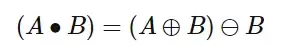




The Opening is a process in which first erosion operation is performed and then dilation operation is performed.


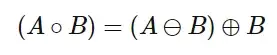

In [ ]:
def erosion(img,k):
  img1 = img
  m,n = img.shape

  SE= np.ones((k,k), dtype=np.uint8)
  constant= (k-1)//2

  imgErode= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img1[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE
      imgErode[i,j]= np.min(product)

  return imgErode

def dilat(img,k):
  img1 = img
  m,n = img.shape

  SE= np.ones((k,k), dtype=np.uint8)
  constant= (k-1)//2

  imgdilat= np.zeros((m,n), dtype=np.uint8)

  for i in range(constant, m-constant):
    for j in range(constant,n-constant):
      temp= img1[i-constant:i+constant+1, j-constant:j+constant+1]
      product= temp*SE
      imgdilat[i,j]= np.max(product)

  return imgdilat


Dilated = dilat(left_imgs[0],15)
Dilated1 = dilat(left_imgs[1],15)

open = dilat(erosion(left_imgs[0],15),15) 
closed = erosion(dilat(left_imgs[0],15),15)

In [ ]:
erode = erosion(left_imgs[0],15)
erode1 = erosion(left_imgs[1],15)

In [ ]:
open1 = dilat(erosion(left_imgs[1],15),15)
closed1 = erosion(dilat(left_imgs[1],15),15)

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(30,10))

ax[0,0].title.set_text('Eroded Image 1')
ax[0,0].imshow(erode, cmap='gray')
ax[0,0].axis('off')

ax[1,0].title.set_text('Eroded Image 2')
ax[1,0].imshow(erode1, cmap='gray')
ax[1,0].axis('off')

ax[0,1].title.set_text('Dilated Image 1')
ax[0,1].imshow(Dilated, cmap='gray')
ax[0,1].axis('off')

ax[1,1].title.set_text('Dilated Image 2')
ax[1,1].imshow(Dilated1, cmap='gray')
ax[1,1].axis('off')

ax[0,2].title.set_text('Opened Image 1')
ax[0,2].imshow(open, cmap='gray')
ax[0,2].axis('off')

ax[1,2].title.set_text('Opened Image 2')
ax[1,2].imshow(open1, cmap='gray')
ax[1,2].axis('off')

ax[0,3].title.set_text('Closed Image 1')
ax[0,3].imshow(closed, cmap='gray')
ax[0,3].axis('off')

ax[1,3].title.set_text('Closed Image 2')
ax[1,3].imshow(closed1, cmap='gray')
ax[1,3].axis('off')

Boundary detection using Dilation

Boundary extraction is one of the applications of morphological transformations.
This is a simple process in which morphological process is used by using the Dilation. 

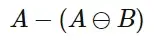


The Process consists of finding the difference between the input image and the dilated image. The boundary will be black in colour and foreground will be white in colour 

In [ ]:
def boundary(img):
  ext_bound = img - erode
  return ext_bound

def boundary1(img):
  ext_bound = img - erode1
  return ext_bound

In [ ]:
b1=boundary(left_imgs[0])
b2=boundary1(left_imgs[1])

In [ ]:

fig, ax = plt.subplots(2,3,figsize=(20,10))

ax[0,0].title.set_text('Orignal Image 1')
ax[0,0].imshow(left_imgs[0], cmap='gray')
ax[0,0].axis('off')

ax[1,0].title.set_text('Original Image 2')
ax[1,0].imshow(left_imgs[1], cmap='gray')
ax[1,0].axis('off')

ax[0,1].title.set_text('Dilated Image Mask')
ax[0,1].imshow(Dilated, cmap='gray')
ax[0,1].axis('off')

ax[1,1].title.set_text('Dilated Image Mask')
ax[1,1].imshow(Dilated1, cmap='gray')
ax[1,1].axis('off')

ax[0,2].title.set_text('Image 1 Boundary')
ax[0,2].imshow(b1, cmap='gray')
ax[0,2].axis('off')

ax[1,2].title.set_text('Image 2 Boundary')
ax[1,2].imshow(b2, cmap='gray')
ax[1,2].axis('off')

Otsu's Algorithm

In [ ]:

test_img = imgs[0]
plt.imshow(test_img,cmap='gray')

### Algorithm
<ol>
<li> Plot the histogram 
<li> The image passed must be filtered and no noise must be present. Since this was taken care by previous preprocessing steps, the histogram is sure to be binarized 

![image.png](attachment:image.png)

<li> Using the above formula the histogram is plotted on a range of values from 0-255 on the X-axis and the count of each pixels in the Y-axis

<li> The following metrics are to be calculated:

![image.png](attachment:image-2.png)
<ol>
    <li> Weights
    <li> Variance 
    <li> Mean
</ol>

<li> Within class variance

![image.png](attachment:image-3.png)

<li> Between class variance 

![image.png](attachment:image-4.png)
<li> Using within class variance the possible thresholding values are added to the dictionary
<li> Finally using the get_optimal_threshold method the best threshold is chosen from the dictionary. That chosen threshold is applied as the global threshold on the image.

In [ ]:
class otsu:

    def __init__(self, img):
        self.img = img
        self.threshold_values = {}
        self.h = [1]

    def Hist(self):
        row, col = self.img.shape 
        y = np.zeros(256)
        for i in range(0,row):
            for j in range(0,col):
                y[self.img[i,j]] += 1
        return y

    def countPixel(self):
        self.h = self.Hist()
        cnt = 0
        for i in range(0, len(self.h)):
            if self.h[i]>0:
                cnt += self.h[i]
        return cnt

    def weight(self, s, e):
        w = 0
        for i in range(s, e):
            w += self.h[i]
        return w

    def mean(self, s, e):
        m = 0
        w = self.weight(s, e)
        for i in range(s, e):
            m += self.h[i] * i
        return m/float(w)

    def variance(self, s, e):
        v = 0
        m = self.mean(s, e)
        w = self.weight(s, e)
        for i in range(s, e):
            v += ((i - m) **2) * self.h[i]
        v /= w
        return v
    
    def threshold(self):
        cnt = self.countPixel()
        for i in range(1, len(self.h)):
            vb = self.variance(0, i)
            wb = self.weight(0, i) / float(cnt)
            mb = self.mean(0, i)
            
            vf = self.variance(i, len(self.h))
            wf = self.weight(i, len(self.h)) / float(cnt)
            mf = self.mean(i, len(self.h))
            
            V2w = wb * (vb) + wf * (vf)
            V2b = wb * wf * (mb - mf)**2
            
            if not math.isnan(V2w):
                self.threshold_values[i] = V2w
    
    def get_optimal_threshold(self):
        min_V2w = min(self.threshold_values.values())
        optimal_threshold = [k for k, v in self.threshold_values.items() if v == min_V2w]
        return optimal_threshold[0]

def otsu_thresholding(image):
    img = image.astype('int8')
    ot = otsu(img)
    x = np.arange(0,256)
    h = ot.Hist()
    ot.threshold()
    op_thres = ot.get_optimal_threshold()

    plt.title(f"Optimal threshold {op_thres}")
    plt.bar(x, h, color='b', width=5, align='center', alpha=0.25)

    fig, ax = plt.subplots(1,2,figsize=(20,9))

    ax[0].title.set_text('Original Image')
    ax[0].imshow(image,cmap='gray')
    ax[0].axis('off')

    ax[1].title.set_text('After Otsu Thresholding')
    ax[1].imshow(image>op_thres,cmap='gray');
    ax[1].axis('off')


Outdoor Images Dataset

In [ ]:
# Randomly picking 4 outdoor dataset images
import random
res = random.sample(range(0, imgs.shape[0]), 4)
otsu_thresholding(imgs[res[0]])


In [ ]:
otsu_thresholding(imgs[res[1]])

In [ ]:
otsu_thresholding(imgs[res[2]])

In [ ]:
otsu_thresholding(imgs[res[3]])

<b> Indoor images dataset

In [ ]:
res = random.sample(range(0, left_imgs.shape[0]), 2)
otsu_thresholding(left_imgs[res[0]])

In [ ]:
otsu_thresholding(left_imgs[res[1]])

In [ ]:
res = random.sample(range(0, right_imgs.shape[0]), 2)
otsu_thresholding(right_imgs[res[0]])

In [ ]:
otsu_thresholding(right_imgs[res[1]])

#### Using smoothing techniques to improve global threshold

<b> Outdoor Dataset

In [ ]:
import cv2

res = random.sample(range(0, imgs.shape[0]), 1)
fig, ax = plt.subplots(1,2,figsize=(20,9))

ax[0].title.set_text('Original Image')
ax[0].imshow(imgs[res[0]],cmap='gray')
ax[0].axis('off')

test_img_smooth = cv2.GaussianBlur(imgs[res[0]], (7,7),0)

ax[1].title.set_text('Smooth image')
ax[1].imshow(test_img_smooth,cmap='gray')
ax[1].axis('off')

Thresholding the Original Image

In [ ]:
otsu_thresholding(imgs[res[0]])

<b> Thresholding smoothened version of original image

In [ ]:
otsu_thresholding(test_img_smooth)

<b> Indoor dataset

In [ ]:
res = random.sample(range(0, left_imgs.shape[0]), 1)
fig, ax = plt.subplots(1,2,figsize=(20,9))

ax[0].title.set_text('Original Image')
ax[0].imshow(left_imgs[res[0]],cmap='gray')
ax[0].axis('off')

test_img_smooth = cv2.GaussianBlur(left_imgs[res[0]], (7,7),0)

ax[1].title.set_text('Smooth image')
ax[1].imshow(test_img_smooth,cmap='gray')
ax[1].axis('off')

<b> Thresholding original image

In [ ]:
otsu_thresholding(left_imgs[res[0]])

<b> Thresholding smoothened version of the original image

In [ ]:
otsu_thresholding(test_img_smooth)

#### Using edges to improve global threshold

<b> Outdoor dataset

In [ ]:
res = random.sample(range(0, imgs.shape[0]), 1)
fig, ax = plt.subplots(1,3,figsize=(20,9))

ax[0].title.set_text('Original Image')
ax[0].imshow(imgs[res[0]],cmap='gray')
ax[0].axis('off')

test_img_smooth = cv2.GaussianBlur(imgs[res[0]], (7,7),0)
laplacian = cv2.Laplacian(test_img_smooth,cv2.CV_64F)

ax[1].title.set_text('Laplacian Image')
ax[1].imshow(laplacian,cmap='gray')
ax[1].axis('off')

test_edge_enhanced = test_img_smooth-laplacian

ax[2].title.set_text('Edge enhanced Image')
ax[2].imshow(test_edge_enhanced, cmap='gray')
ax[2].axis('off')

<b> Thresholding original image

In [ ]:
otsu_thresholding(imgs[res[0]])

<b> Thresholding edge enhanced image

In [ ]:
otsu_thresholding(test_edge_enhanced)

<b> Indoor dataset

In [ ]:
res = random.sample(range(0, left_imgs.shape[0]), 1)
fig, ax = plt.subplots(1,3,figsize=(20,9))

ax[0].title.set_text('Original Image')
ax[0].imshow(left_imgs[res[0]],cmap='gray')
ax[0].axis('off')

test_img_smooth = cv2.GaussianBlur(left_imgs[res[0]], (7,7),0)
laplacian = cv2.Laplacian(test_img_smooth,cv2.CV_64F)

ax[1].title.set_text('Laplacian Image')
ax[1].imshow(laplacian,cmap='gray')
ax[1].axis('off')

test_edge_enhanced = test_img_smooth-laplacian

ax[2].title.set_text('Edge enhanced Image')
ax[2].imshow(test_edge_enhanced, cmap='gray')
ax[2].axis('off')

<b> Thresholding original image

In [ ]:
otsu_thresholding(left_imgs[res[0]])

<b> Thresholding edge enhanced image

In [ ]:
otsu_thresholding(test_edge_enhanced)

#### Multiple threshold

In [ ]:
res = random.sample(range(0, imgs.shape[0]), 1)
img = imgs[res[0]]
a = 0
b = 255
n = 4 # number of thresholds (better choose even value)
k = 0.7 # free variable to take any positive value
T = [] # list which will contain 'n' thresholds

In [ ]:
def multiThresh(img, a, b):
    if a>b:
        s=-1
        m=-1
        return m,s

    img = np.array(img)
    t1 = (img>=a)
    t2 = (img<=b)
    X = np.multiply(t1,t2)
    Y = np.multiply(img,X)
    s = np.sum(X)
    m = np.sum(Y)/s
    return m,s

for i in range(int(n/2-1)):
    img = np.array(img)
    t1 = (img>=a)
    t2 = (img<=b)
    X = np.multiply(t1,t2)
    Y = np.multiply(img,X)
    mu = np.sum(Y)/np.sum(X)

    Z = Y - mu
    Z = np.multiply(Z,X)
    W = np.multiply(Z,Z)
    sigma = math.sqrt(np.sum(W)/np.sum(X))

    T1 = mu - k*sigma
    T2 = mu + k*sigma

    x, y = multiThresh(img, a, T1)
    w, z = multiThresh(img, T2, b)

    T.append(x)
    T.append(w)

    a = T1+1
    b = T2-1
    k = k*(i+1)

T1 = mu
T2 = mu+1
x, y = multiThresh(img, a, T1)
w, z = multiThresh(img, T2, b)    
T.append(x)
T.append(w)
T.sort()
print(T)

In [ ]:
def print_multi_otsu():
    image = img

    # Applying multi-Otsu threshold for the default value, generating
    # three classes.
    thresholds =T

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(image, bins=thresholds)
    
    plt.hist(image.ravel(), bins=255)
    plt.title('Histogram')
    for thresh in thresholds:
        plt.axvline(thresh, color='r')


    fig, ax = plt.subplots(1,2, figsize=(20,9))

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    

    # Plotting the original image.
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    # Plotting the Multi Otsu result.
    ax[1].imshow(regions, cmap='jet')
    ax[1].set_title('Multi-Otsu result')
    ax[1].axis('off')

    plt.subplots_adjust()

    plt.show()

<b> Outdoor Dataset

In [ ]:
print_multi_otsu()

<b> Indoor dataset

In [ ]:
res = random.sample(range(0, left_imgs.shape[0]), 1)
img = left_imgs[res[0]]
a = 0
b = 255
n = 2 # number of thresholds (better choose even value)
k = 0.7 # free variable to take any positive value
T = [] # list which will contain 'n' thresholds

In [ ]:
def multiThresh(img, a, b):
    if a>b:
        s=-1
        m=-1
        return m,s

    img = np.array(img)
    t1 = (img>=a)
    t2 = (img<=b)
    X = np.multiply(t1,t2)
    Y = np.multiply(img,X)
    s = np.sum(X)
    m = np.sum(Y)/s
    return m,s

for i in range(int(n/2-1)):
    img = np.array(img)
    t1 = (img>=a)
    t2 = (img<=b)
    X = np.multiply(t1,t2)
    Y = np.multiply(img,X)
    mu = np.sum(Y)/np.sum(X)

    Z = Y - mu
    Z = np.multiply(Z,X)
    W = np.multiply(Z,Z)
    sigma = math.sqrt(np.sum(W)/np.sum(X))

    T1 = mu - k*sigma
    T2 = mu + k*sigma

    x, y = multiThresh(img, a, T1)
    w, z = multiThresh(img, T2, b)

    T.append(x)
    T.append(w)

    a = T1+1
    b = T2-1
    k = k*(i+1)

T1 = mu
T2 = mu+1
x, y = multiThresh(img, a, T1)
w, z = multiThresh(img, T2, b)    
T.append(x)
T.append(w)
T.sort()
print(T)

In [ ]:
print_multi_otsu()

#### Variable thresholding using moving average

In [ ]:
class variable_thresholding:
    def __init__(self, img):
        self.img = img
    def thresholdIntegral(self, inputMat,s,T = 0.15):
        outputMat=np.zeros(inputMat.shape)
        nRows = inputMat.shape[0]
        nCols = inputMat.shape[1]
        S = int(max(nRows, nCols) / 8)

        s2 = int(S / 4)

        for i in range(nRows):
            y1 = i - s2
            y2 = i + s2

            if (y1 < 0) :
                y1 = 0
            if (y2 >= nRows):
                y2 = nRows - 1

            for j in range(nCols):
                x1 = j - s2
                x2 = j + s2

                if (x1 < 0) :
                    x1 = 0
                if (x2 >= nCols):
                    x2 = nCols - 1
                count = (x2 - x1)*(y2 - y1)

                sum=s[y2][x2]-s[y2][x1]-s[y1][x2]+s[y1][x1]

                if ((int)(inputMat[i][j] * count) < (int)(sum*(1.0 - T))):
                    outputMat[i][j] = 255
        return outputMat



    def local_thresholding(self):
        otsu_thresholding(self.img)
        ratio=1
        roii = cv2.integral(self.img)
        thresh = self.thresholdIntegral(self.img, roii)
        fig,ax = plt.subplots(1,2,figsize=(20,9))
        ax[0].title.set_text("Original image")
        ax[0].imshow(self.img,cmap='gray')
        ax[0].axis('off')

        ax[1].title.set_text("Local thresholding")
        ax[1].imshow(thresh,cmap='gray')
        ax[1].axis('off')
    

<b> Outdoor dataset

In [ ]:
vt = variable_thresholding(imgs[2])
vt.local_thresholding()

In [ ]:
vt2 = variable_thresholding(imgs[9])
vt2.local_thresholding()

<b> Indoor dataset

In [ ]:
vt2 = variable_thresholding(left_imgs[9])
vt2.local_thresholding()

In [ ]:
vt2 = variable_thresholding(right_imgs[13])
vt2.local_thresholding()

<b> Canny Edge Detector

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(left_imgs[3],cmap='gray')

In [ ]:
import cv2 as cv
img = np.uint8(left_imgs[3])
blurred = cv2.GaussianBlur(img, (5,5), 0)
edge = cv.Canny(img, 50, 150)
edge1 = cv.Canny(blurred, 50, 150)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(edge,cmap='gray')
#plt.imshow(edge1,cmap='gray')

In [ ]:
plt.figure(figsize=(10,10))
#plt.imshow(edge,cmap='gray')
plt.imshow(edge1,cmap='gray')

In [ ]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = cv2.filter2D(src=left_imgs[3], ddepth=-1, kernel=kernel)
plt.figure(figsize=(10,10))
plt.imshow(image_sharp,cmap='gray')

In [ ]:
image_sharp = np.uint8(left_imgs[3])
edge2 = cv.Canny(image_sharp, 50, 150)
plt.figure(figsize=(10,10))
plt.imshow(edge2,cmap='gray')

Canny Edge Detector from Scratch

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
def sHalf(T, sigma):
    temp = -np.log(T) * 2 * (sigma ** 2)
    return np.round(np.sqrt(temp))

def calculate_filter_size(T, sigma):
    return 2*sHalf(T, sigma) + 1

In [ ]:
def MaskGeneration(T, sigma):
    N = calculate_filter_size(T, sigma)
    shalf = sHalf(T, sigma)
    y, x = np.meshgrid(range(-int(shalf), int(shalf) + 1), range(-int(shalf), int(shalf) + 1))
    return x, y

In [ ]:
def Gaussian(x,y, sigma):
    temp = ((x ** 2) + (y ** 2)) / (2 * (sigma ** 2))
    return (np.exp(-temp))

def calculate_gradient_X(x,y, sigma):
    temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((x * np.exp(-temp)) / sigma ** 2)

def calculate_gradient_Y(x,y, sigma):
    temp = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    return -((y * np.exp(-temp)) / sigma ** 2)

In [ ]:
def pad(img, kernel):
    r, c = img.shape
    kr, kc = kernel.shape
    padded = np.zeros((r + kr,c + kc), dtype=img.dtype)
    insert = int((kr)//2)
    padded[insert: insert + r, insert: insert + c] = img
    return padded
            
def smooth(img, kernel=None):
    if kernel is None:
        mask = np.array([[1,1,1],[1,1,1],[1,1,1]])
    else:
        mask = kernel
    i, j = mask.shape
    output = np.zeros((img.shape[0], img.shape[1]))           
    image_padded = pad(img, mask)
    for x in range(img.shape[0]):    
        for y in range(img.shape[1]):
            output[x, y] = (mask * image_padded[x:x+i, y:y+j]).sum() / mask.sum()  
    return output


In [ ]:
def Create_Gx(fx, fy):
    gx = calculate_gradient_X(fx, fy, sigma)
    gx = (gx * 255)
    return np.around(gx)

def Create_Gy(fx, fy):    
    gy = calculate_gradient_Y(fx, fy, sigma)
    gy = (gy * 255)
    return np.around(gy)

In [ ]:
def ApplyMask(image, kernel):
    i, j = kernel.shape
    kernel = np.flipud(np.fliplr(kernel))    
    output = np.zeros_like(image)           
    image_padded = pad(image, kernel)
    for x in range(image.shape[0]):    
        for y in range(image.shape[1]):
            output[x, y] = (kernel * image_padded[x:x+i, y:y+j]).sum()        
    return output

In [ ]:
def Gradient_Magnitude(fx, fy):
    mag = np.zeros((fx.shape[0], fx.shape[1]))
    mag = np.sqrt((fx ** 2) + (fy ** 2))
    mag = mag * 100 / mag.max()
    return np.around(mag)

def Gradient_Direction(fx, fy):
    g_dir = np.zeros((fx.shape[0], fx.shape[1]))
    g_dir = np.rad2deg(np.arctan2(fy, fx)) + 180
    return g_dir

In [ ]:
def Digitize_angle(Angle):
    quantized = np.zeros((Angle.shape[0], Angle.shape[1]))
    for i in range(Angle.shape[0]):
        for j in range(Angle.shape[1]):
            if 0 <= Angle[i, j] <= 22.5 or 157.5 <= Angle[i, j] <= 202.5 or 337.5 < Angle[i, j] < 360:
                quantized[i, j] = 0
            elif 22.5 <= Angle[i, j] <= 67.5 or 202.5 <= Angle[i, j] <= 247.5:
                quantized[i, j] = 1
            elif 67.5 <= Angle[i, j] <= 122.5 or 247.5 <= Angle[i, j] <= 292.5:
                quantized[i, j] = 2
            elif 112.5 <= Angle[i, j] <= 157.5 or 292.5 <= Angle[i, j] <= 337.5:
                quantized[i, j] = 3
    return quantized
    
def Non_Max_Supp(qn, magni, D):
    M = np.zeros(qn.shape)
    a, b = np.shape(qn)
    for i in range(a-1):
        for j in range(b-1):
            if qn[i,j] == 0:
                if  magni[i,j-1]< magni[i,j] or magni[i,j] > magni[i,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j]==1:
                if  magni[i-1,j+1]<= magni[i,j] or magni[i,j] >= magni[i+1,j-1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0       
            if qn[i,j] == 2:
                if  magni[i-1,j]<= magni[i,j] or magni[i,j] >= magni[i+1,j]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
            if qn[i,j] == 3:
                if  magni[i-1,j-1]<= magni[i,j] or magni[i,j] >= magni[i+1,j+1]:
                    M[i,j] = D[i,j]
                else:
                    M[i,j] = 0
    return M

def color(quant, mag):
    color = np.zeros((mag.shape[0], mag.shape[1], 3), np.uint8)
    a, b = np.shape(mag)
    for i in range(a-1):
        for j in range(b-1):
            if quant[i,j] == 0:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                else:
                    color[i,j,0] = 0
            if quant[i,j] == 1:
                if mag[i,j] != 0:
                    color[i,j,1] = 255
                else:
                    color[i,j,1] = 0
            if quant[i,j] == 2:
                if mag[i,j] != 0:
                    color[i,j,2] = 255
                else:
                    color[i,j,2] = 0
            if quant[i,j] == 3:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                    color[i,j,1] = 255
                    
                else:
                    color[i,j,0] = 0
                    color[i,j,1] = 0
    return color

In [ ]:
def _double_thresholding(g_suppressed, low_threshold, high_threshold):
    g_thresholded = np.zeros(g_suppressed.shape)
    for i in range(0, g_suppressed.shape[0]):		# loop over pixels
        for j in range(0, g_suppressed.shape[1]):
            if g_suppressed[i,j] < low_threshold:	# lower than low threshold
                g_thresholded[i,j] = 0
            elif g_suppressed[i,j] >= low_threshold and g_suppressed[i,j] < high_threshold: 	# between thresholds
                g_thresholded[i,j] = 128
            else:					        # higher than high threshold
                g_thresholded[i,j] = 255
    return g_thresholded

def _hysteresis(g_thresholded):
    g_strong = np.zeros(g_thresholded.shape)
    for i in range(0, g_thresholded.shape[0]):		# loop over pixels
        for j in range(0, g_thresholded.shape[1]):
            val = g_thresholded[i,j]
            if val == 128:			# check if weak edge connected to strong
                if g_thresholded[i-1,j] == 255 or g_thresholded[i+1,j] == 255 or g_thresholded[i-1,j-1] == 255 or g_thresholded[i+1,j-1] == 255 or g_thresholded[i-1,j+1] == 255 or g_thresholded[i+1,j+1] == 255 or g_thresholded[i,j-1] == 255 or g_thresholded[i,j+1] == 255:
                    g_strong[i,j] = 255		# replace weak edge as strong
            elif val == 255:
                g_strong[i,j] = 255		# strong edge remains as strong edge
    return g_strong

# Step 1 Specify sigma and T value Also calculate Gradient masks
Here you will give the values of sigma and T(0-1). This will create the size of filter automatically. We generate gradient masks in x and y directions i.e. Gx and Gy

In [ ]:
sigma = 0.5
T = 0.3
x, y = MaskGeneration(T, sigma)
gauss = Gaussian(x, y, sigma)

In [ ]:
gx = -Create_Gx(x, y)
gy = -Create_Gy(x, y)

# Step 2 Reading and converting image into grayscale
Here we convert the image into grayscale image for easy processing and finding edges

In [ ]:
right_imgs[8].shape

In [ ]:
gray = right_imgs[8]
plt.figure(figsize = (7,7))
plt.imshow(gray, cmap='gray')
plt.show()

## Smoothing
Here we smooth the image to reduce the intensity in the pixels

In [ ]:
smooth_img = smooth(gray,gauss)
plt.figure(figsize = (7,7))
plt.imshow(smooth_img, cmap='gray')

# Step 3 Applying the Gradient masks
In this step we apply the gradient x and y masks on the image.

In [ ]:
gx.shape

In [ ]:
fx = ApplyMask(smooth_img, gx)
plt.figure(figsize = (7,7))
plt.imshow(fx, cmap='gray')

In [ ]:
fy = ApplyMask(smooth_img, gy)
plt.figure(figsize = (7,7))
plt.imshow(fy, cmap='gray')

# Step 4 Gradient magnitude
In this step we calculate the gradient magnitude at every pixel location

In [ ]:
mag = Gradient_Magnitude(fx, fy)
mag = mag.astype(int)
plt.figure(figsize = (7,7))
plt.imshow(mag, cmap='gray')
print('max', mag.max())
print('min', mag.min())

# STEP 5 Gradient Direction
In this step we find direction of gradient at each pixel of the image.

In [ ]:
Angle = Gradient_Direction(fx, fy)
plt.figure(figsize = (7,7))
plt.imshow(Angle, cmap='gray')
print('max', Angle.max())
print('min', Angle.min())

# Step 6 Quantization of angles and Non-Max Suppression
In this step we quantize our angles into 4 groups 0, 1, 2, 3. Then we apply non-maximum suppression on it to make the edges thin

In [ ]:
quantized = Digitize_angle(Angle)
nms = Non_Max_Supp(quantized, Angle, mag)
plt.figure(figsize = (7,7))
plt.imshow(nms, cmap='gray')
print('max', nms.max())
print('min', nms.min())

### Colorized Image for visualiztion of angles

In [ ]:
colorized = color(quantized, mag)
plt.figure(figsize = (7,7))
plt.imshow(colorized)
cv2.imwrite('color.jpg',colorized)

# Step 7 Double Threshold and Hysteresis
In this step we apply double threshold Tl and Th to our non-maximum suppressed images. After that we apply Hysteresis algorithm to get resultant edges of the image.

In [ ]:
threshold = _double_thresholding(nms,3,8)
cv2.imwrite('double_thresholded.jpg', threshold )
plt.figure(figsize = (10,10))
plt.imshow(threshold, cmap='gray')

In [ ]:
hys = _hysteresis(threshold)
plt.figure(figsize = (10,10))
plt.imshow(hys, cmap='gray')

### Hough Transform

In [ ]:
smooth_img = cv2.GaussianBlur(left_imgs[20], (3,3), 0)
plt.figure(figsize = (10,10))
plt.imshow(smooth_img, cmap='gray')

In [ ]:
smooth_img1 = np.uint8(smooth_img)
edge2 = cv.Canny(smooth_img1, 50, 150)
minLineLength = 10
maxLineGap = 10
lines = cv2.HoughLinesP(edge2,1,np.pi/180,50,minLineLength,maxLineGap)
for line in lines:
   for x1,y1,x2,y2 in line:
      cv2.line(smooth_img1,(x1,y1),(x2,y2),(0,255,0),2)
plt.figure(figsize=(10,10))
plt.imshow(smooth_img1,cmap='gray')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(edge2,cmap='gray')

Hough transform from scratch

In [ ]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt


# The Hough Transform is a popular algorithm for detecting any shape that can
# be represented in a parametric mathmatical form in binary images. This
# usually means that images need to be thresholded or filtered prior to running
# the Hough Transform.

# read in shapes image and convert to grayscale
shapes = left_imgs[20]
# blur image (this will help clean up noise for Canny Edge Detection)
# see Chapter 2.0 for Guassian Blur or check OpenCV documentation
shapes_blurred = cv2.GaussianBlur(shapes,(3,3),0)
shapes_blurred1 = np.uint8(shapes_blurred)
# find Canny Edges and show resulting image
canny_edges = cv2.Canny(shapes_blurred1, 50, 150)
plt.figure(figsize=(10,10))
plt.imshow(canny_edges,cmap='gray')


In [ ]:

########################################### HOUGH LINES FROM SCRATCH USING NUMPY
# Step 1: The Hough transform needs a binary edges images.  For this particular
# python file, I used the openCV built in Class Canny to create this edge image
# from the original shapes.png file.

# This is the function that will build the Hough Accumulator for the given image
def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    ''' A function for creating a Hough Accumulator for lines in an image. '''
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes

    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas


# This is a simple peaks function that just finds the indicies of the number
# of maximum values equal to num_peaks.  You have to be careful here though, if
# there's any noise in the image it will like create a 'pocket' of local maxima
# values.  This function ignores this and in turn has the tendancy to return
# multiple lines along an actual line in the image.
def hough_simple_peaks(H, num_peaks):
    ''' A function that returns the number of indicies = num_peaks of the
        accumulator array H that correspond to local maxima. '''
    indices =  np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T


# This more advance Hough peaks funciton has threshold and nhood_size arguments
# threshold will threshold the peak values to be above this value if supplied,
# where as nhood_size will surpress the surrounding pixels centered around
# the local maximum after that value has been assigned as a peak.  This will
# force the algorithm to look eslwhere after it's already selected a point from
# a 'pocket' of local maxima.
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    ''' A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpessed. '''
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size/2)) < 0: 
          min_x = 0
        else: 
          min_x = int(idx_x - (nhood_size/2))
        if ((idx_x + (nhood_size/2) + 1) > H.shape[1]): 
          max_x = H.shape[1]
        else: 
          max_x = int(idx_x + (nhood_size/2) + 1)

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size/2)) < 0: 
          min_y = 0
        else: 
          min_y = int(idx_y - (nhood_size/2))
        if ((idx_y + (nhood_size/2) + 1) > H.shape[0]): 
          max_y = H.shape[0]
        else: 
          max_y = int(idx_y + (nhood_size/2) + 1)

        # bound each index by the neighborhood size and set all values to 0
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H

# drawing the lines from the Hough Accumulatorlines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    ''' A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. '''
    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (0,255,0), 2)


# run hough_lines_accumulator on the shapes canny_edges image
H, rhos, thetas = hough_lines_acc(canny_edges)
indicies, H = hough_peaks(H, 3, nhood_size=11) # find peaks
hough_lines_draw(shapes, indicies, rhos, thetas)
plt.figure(figsize=(10,10))
# Show image with manual Hough Transform Lines
plt.imshow(shapes,cmap='gray')

### Sobel and Prewitt edge detection

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
gray = right_imgs[20]
img_gaussian = np.uint8(cv2.GaussianBlur(gray,(3,3),0))

#canny
img_canny = cv2.Canny(img_gaussian,50,150)

#sobel
img_sobely = cv2.Sobel(img_gaussian,cv2.CV_8U,1,0,ksize=5)
img_sobelx = cv2.Sobel(img_gaussian,cv2.CV_8U,0,1,ksize=5)
img_sobel = img_sobelx + img_sobely


#prewitt
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv2.filter2D(img_gaussian, -1, kernelx)
img_prewitty = cv2.filter2D(img_gaussian, -1, kernely)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 4,figsize=(20,8))

ax[0, 0].imshow(gray,cmap='gray')
ax[0,0].title.set_text('Original image')
ax[0,0].axis('off')
ax[1, 0].imshow(img_canny,cmap='gray')
ax[1, 0].title.set_text('Canny Edge Detector')
ax[1, 0].axis('off')
ax[0, 1].imshow(img_sobelx,cmap='gray')
ax[0, 1].title.set_text('Sobel - X')
ax[0, 1].axis('off')
ax[1, 1].imshow(img_prewittx,cmap='gray')
ax[1, 1].title.set_text('Prewitt - X')
ax[1, 1].axis('off')
ax[0,2].imshow(img_sobely,cmap='gray')
ax[0,2].title.set_text('Sobel - Y')
ax[0,2].axis('off')
ax[1,2].imshow(img_prewitty,cmap='gray')
ax[1,2].title.set_text('Prewitt - Y')
ax[1,2].axis('off')
ax[0,3].imshow(img_sobel,cmap='gray')
ax[0,3].title.set_text('Final Sobel')
ax[0,3].axis('off')
ax[1,3].imshow(img_prewittx + img_prewitty,cmap='gray')
ax[1,3].title.set_text('Final Prewitt')
ax[1,3].axis('off')
fig.show()


### Contour detection

In [ ]:
import cv2

image = left_imgs[10]
blurred = np.uint8(cv2.GaussianBlur(image, (5, 5), 0))
edged = cv2.Canny(blurred, 50, 150)
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(image,cmap='gray')
ax[0].title.set_text("Original image")
ax[0].axis('off')
ax[1].imshow(edged,cmap='gray')
ax[1].title.set_text("Edged Image")
ax[1].axis('off')

In [ ]:
# find the contours in the edged image
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = image.copy()
# draw the contours on a copy of the original image
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
print(len(contours), "objects were found in this image.")
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(edged,cmap='gray')
ax[0].title.set_text("Edged image")
ax[0].axis('off')
ax[1].imshow(image_copy,cmap='gray')
ax[1].title.set_text("Contours")
ax[1].axis('off')


In [ ]:
# define a (3, 3) structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# apply the dilation operation to the edged image
dilate = cv2.dilate(edged, kernel, iterations=1)

# find the contours in the dilated image
contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = image.copy()
# draw the contours on a copy of the original image
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
print(len(contours), "objects were found in this image.")
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(dilate,cmap='gray')
ax[0].title.set_text("Dilated image")
ax[0].axis('off')
ax[1].imshow(image_copy,cmap='gray')
ax[1].title.set_text("Contours")
ax[1].axis('off')


<b> Marr Hildreth Edge Detector

In [ ]:
import argparse
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import glob
import cv2 as cv
%matplotlib inline


def edgesMarrHildreth(img, sigma):
    """
            finds the edges using MarrHildreth edge detection method...
            :param im : input image
            :param sigma : sigma is the std-deviation and refers to the spread of gaussian
            :return:
            a binary edge image...
    """
    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                       np.arange(-size/2+1, size/2+1))

    normal = 1 / (2.0 * np.pi * sigma**2)

    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * \
        np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal  # LoG filter

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # applying filter
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i, j] = np.sum(window)

    log = log.astype(np.int64, copy=False)

    zero_crossing = np.zeros_like(log)

    # computing zero crossing
    for i in range(log.shape[0]-(kern_size-1)):
        for j in range(log.shape[1]-(kern_size-1)):
            if log[i][j] == 0:
                if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                    zero_crossing[i][j] = 255
            if log[i][j] < 0:
                if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                    zero_crossing[i][j] = 255

    # plotting images
    # fig = plt.figure()
    # a = fig.add_subplot(1, 2, 1)
    # imgplot = plt.imshow(log, cmap='gray')
    # a.set_title('Laplacian of Gaussian')
    # a = fig.add_subplot(1, 2, 2)
    # imgplot = plt.imshow(zero_crossing, cmap='gray')
    # string = 'Zero Crossing sigma = '
    # string += (str(sigma))
    # a.set_title(string)
    # plt.show()

    return log, zero_crossing


def main():
    # oparser = argparse.ArgumentParser(description="Marr-Hildreth Edge detector")
    # oparser.add_argument("--input", dest="input_image", required=True,
    #                      help="Path containing the image")
    # oparser.add_argument("--output", dest="output_image", required=True,
    #                      help="Path containing the image")
    # oparser.add_argument("--sigma", dest="sigma", default=3, required=False,
    #                      help="Sigma threshold", type=int)
    # options = oparser.parse_args()

    # img = io.imread(options.input_image)
    # img = color.rgb2gray(img)

    # log, zero_crossing = edgesMarrHildreth(img, options.sigma)

    # io.imsave(f'{options.output_image}_{options.sigma}_log.jpg', log)
    # io.imsave(f'{options.output_image}_{options.sigma}_zero_crossing.jpg', zero_crossing)
    while(1):
      imgs=left_imgs[0]
      log,zero_crossing=edgesMarrHildreth(imgs, 3)
      plt.figure(figsize=(10,10))
      plt.title('Input Image')
      plt.imshow(imgs, cmap='gray')
      plt.axis('off')
      plt.show()
      plt.figure(figsize=(10,10))
      plt.title('Laplacian of Gaussian')
      plt.imshow(log, cmap='gray')
      plt.axis('off')
      plt.show()
      plt.figure(figsize=(10,10))
      plt.title('Marr Hildreth with zero crossing')
      plt.imshow(zero_crossing, cmap='gray')
      plt.axis('off')
      plt.show()
      return 0


main()

<b> Clustering

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image

def clust_gray(image,k=5,iters=3): # expects img in grayscale
    # image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img=image.copy()
    h,w=img.shape
    orig=image.copy()
    Klusters=np.random.randint(0,255,size=k)
    print('init clusters', Klusters)
    for it in range(iters):
        img=image.copy()
        for i in range(h):
            for j in range(w):
                pnt=img[i][j]
                diff=np.abs(Klusters-pnt)
                c=np.argmin(diff)
                img[i][j]=Klusters[c]
        loss=0
        l=[]
        for i in range(k):
            Ys,Xs=np.where(img==Klusters[i])
            kth_points=orig[Ys,Xs]
            l.append(np.sum(Klusters[i]-kth_points))
            Klusters[i]=np.mean(kth_points)
        loss=sum(l)    
        print('Cluster centroids at iteration-{}'.format(it+1), Klusters)
        print('loss at iteration-{}'.format(it+1),loss)
    return img
if __name__ == '__main__':
  im = left_imgs[0]
  clusters=clust_gray(im,k=3)
  cv2_imshow(im)
  cv2_imshow(clusters)

<b> Water Shed Segmentation </b>

In geographical sense : An array where water accumulates. It is a land area that channels / drains rain and snow to 
creeks, streams, etc. Watershed can be segmented as topographical maps with boundaries (more lowers the altitude of the land, more water it accumulates). I.E, the gray scale images can be considered to have valleys and peaks, based on the intensity. There is also a threshold that seggregates between the two. The brightness determines the high (peak) and low (valley) in this algorithm.

It works by filling values (i.e local minima), with pixels belonging to the same predefined label. High intensity denotes peaks and hills, while low intensity denotes valley. We fill every local isloated minima and mark it as a different segment. We also create a boundary / barrier between two isolated valleys.

The algorithm is useful for segmenting images into background and forground for certain images where other algorithms fail, for example when the forground has several objects of same / similar intensity, other algorithms will determine that all said objects will be merged to one, while the watershed algorithm prevents this.

However, it fails when RGB image is used (primarily because if objects are not clearly differentiable when we do the thresholding of image). Also, noise can heavily corrupt / bias the result, for which denoising is required as a preprocessing step.

Main use case of this algorithm : Segment individual objects when heavily clustered.

![](https://miro.medium.com/max/828/1*uuk-mzJygthxB6krOObZyw.webp)

In [ ]:
!git clone https://github.com/Shankar0x/DepthSensingDatasets.git images
from PIL import Image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path = 'images/DrivingStereo_dataset/004.jpg'
image = cv2.imread(path)

In [ ]:
color_image = image.copy()

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print('source image')
plt.imshow(image, cmap='gray')
plt.show()

Performing threshold based segmentation

The black regions can be considered as 'surely' background

In [ ]:
def threshold(image, t, inv=False):
  m, n = image.shape
  result = np.zeros((m, n))
  print(m, n)
  for i in range(m):
    for j in range(n):
      #print(image[i,j,0])
      if image[i, j] > t:
        if inv:
          result[i, j] = 0
        else:
          result[i, j] = 255
      else:
          if inv:
            result[i, j] = 255

  return result

In [ ]:
threshold_image = threshold(image, 120, True)

print('source image')
plt.imshow(image, cmap='gray')
plt.show()

print('threshold segmented image [SURE BACKGROUND]')
plt.imshow(threshold_image, cmap='gray')
plt.show()

Sure Background : Result obtained from thresholding

Noise Removal using morphological opening, and dilation to make pixels around boundaries thinner (to now surely what is background), and to also remove small holes within an object.

Then, use dilation to increase object boundaries. This way we can be sure of what is *definitely* the background.

In [ ]:
threshold_image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY_INV)[1]
opening = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
print('mophological opening')
plt.imshow(opening, cmap='gray')
plt.show()

dilation = cv2.dilate(opening, np.ones((3, 3), dtype=np.uint8), iterations=2)
print('dilation')
plt.imshow(dilation, cmap='gray')
plt.show()

Sure Foreground

Distance Transform : As pixels get further away from a bunch of 0's, the intensity increnases. Essentially, the edges are darker, while the center of object is bright.

This is used as small objects tend to get washed away while performing erosion. Can be seen as an alternative to using erosion to determine what componenets are ****'surely' forground**** in this case.

The distance indicates the minimum distance to the closes background (to the region of 0's in the thresholded image).

Unknown region is just the difference between surely foreground and surely background

![](https://miro.medium.com/max/786/1*N2souynjEJN6jk9GszwRaA.webp)

Relevant Research Paper on Distance Transform with implementation: https://cs.brown.edu/people/pfelzens/papers/dt-final.pdf

![](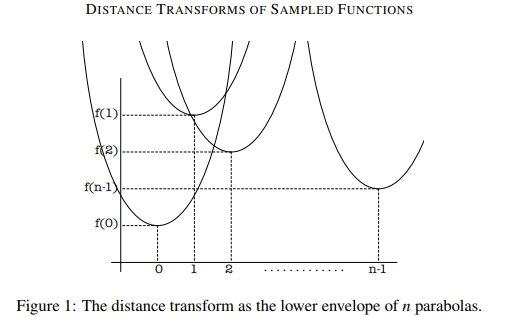)

In [ ]:
# Distance transform for a 1-dimensional vector using city block distance
def distance_transform_1d(v, n, inf=1e20):
    f = v
    d = np.zeros(n, dtype=np.float64)
    v = np.zeros(n, dtype=int)
    z = np.zeros(n+1, dtype=np.float64)
    
    # Locations of boundaries between parabolas
    z[0] = -inf
    z[1] = inf
    
    k = 0       # Index of rightmost parabola in lower envelope
    for q in range(n)[1:]:
        s = ((f[q]+ q*q) - (f[v[k]] + v[k]*v[k]))/(2*q-2*v[k])
        while s<= z[k]:
            k -= 1
            s  = ((f[q]+q*q)-(f[v[k]]+v[k]*v[k]))/(2*q-2*v[k])
        k +=1
        v[k] = q
        z[k] = s
        z[k+1] = inf

    k=0
    for q in range(n):
        while (z[k+1] < q):
            k +=1
        d[q] = (q-v[k])*(q-v[k]) + f[v[k]]
    
    return d

# Distance transform for a 2D image using city block distance
def dt_img(image):
    height = image.shape[0]
    width = image.shape[1]
    # Columns
    for x in range(width):
        f = image[:,x]
        image[:,x] = distance_transform_1d(f, height)
    # Rows
    for y in range(height):
        f = image[y,:]
        d = distance_transform_1d(f, width)
        image[y,:] = d
    return image

# Distance transform for 2D binary image
def distance_transform_binary(image, inf=1e20, on=0):
    height = image.shape[0]
    width = image.shape[1]
    out = np.ones([height, width], dtype=np.float64)*inf # Multiply by infinity 
    out[image==on]=0
    out = dt_img(out)
    
    return out

In [ ]:
plt.imshow(distance_transform_binary(dilation.copy()), cmap='gray')

In [ ]:
dilation = cv2.dilate(opening, np.ones((3, 3), dtype=np.uint8), iterations=2)
dist_transform = cv2.distanceTransform(dilation, cv2.DIST_L2, 5)
forground = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)[1]
print('Distance transform')
plt.imshow(dist_transform, cmap='gray')
plt.show()

print('forground points (sure)')
plt.imshow(forground, cmap='gray')
plt.show()

# Not sure if forground or background
print('unknown')
unknown_region = cv2.subtract(dilation, np.uint8(forground))
plt.imshow(unknown_region, cmap='gray')
plt.show()

Find connected componenets and get markers for each connected component

In [ ]:
markers = cv2.connectedComponents(np.uint8(forground))[1]

# Plus one so background is not 0, but 1
markers=markers+1

# Mark unknown region (not sure if forground or background) with 0's
markers[unknown_region==255] = 0

print('markers')
plt.imshow(markers, cmap='jet')
plt.show()

Using the final watershed algorithm

In [ ]:
watershed_res = cv2.watershed(color_image, markers)

# Make boundaries (marked with -1 as background)
color_image_marked = color_image.copy()

color_image_marked[markers==-1] = [255, 0, 0]

print('markers')
plt.imshow(markers)
plt.show()

print('watershed res')
plt.imshow(color_image_marked)
plt.show()

Scenarios where Water Shed Segmentation is Useful 🇰

<Foreground is clearly distinct from background, with excessive clustering and no overlapping of foreground and bckground> 

![](https://docs.opencv.org/3.4/water_coins.jpg)
![](https://docs.opencv.org/3.4/water_result.jpg)

Morphological Gradient Operator

A simple morphological image processing technique used to find the borders / outline of images.

Consist of two steps : 

(i) Perform erosion to shrink the image based on structuring element. \
(ii)  Subtract eroded image from the dilated  image.

In [ ]:
print('original image')
plt.imshow(image, cmap='gray')
plt.show()

eroded = cv2.erode(image, np.ones((3,3), dtype=np.uint8))
dilate = cv2.dilate(image, np.ones((3,3), dtype=np.uint8))

print('eroded image')
plt.imshow(eroded, cmap='gray')
plt.show()

print('dilate image')
plt.imshow(dilate, cmap='gray')
plt.show()

print('gradient res')
plt.imshow(dilate-eroded, cmap='gray')
plt.show()

Morphological Top Hat Operator

A simple morphological image processing technique used to extract the small and fine details from an image.

It consist of two steps : 

(i) Obtain the 'opening' of the image. \
(ii) Subtract the opening of image from the original image.

In [ ]:
print('original image')
plt.imshow(image, cmap='gray')
plt.show()

eroded = cv2.erode(image, np.ones((3,3), dtype=np.uint8))
opening = cv2.dilate(eroded, np.ones((3,3), dtype=np.uint8))

print('eroded image')
plt.imshow(eroded, cmap='gray')
plt.show()

print('image opening')
plt.imshow(opening, cmap='gray')
plt.show()

print('top hat res')
plt.imshow(image-opening, cmap='gray')
plt.show()

<b> Color Spaces Segmentation </b>

Given an RGB image, we first convert the color space to HSV (Hue Saturation Value). The reason for this is : 

(i) Hue : Gives only color information (based on degrees, where red falls between 0 to 60, yellow falls between 61 to 120, etc).

(ii) Value : The darkness / brightness of the color.

(iii) Saturation : The amount of gray in the image. If this value is 0%, it produces a faded effect and produces more white. On the other hand, if the value is 100%, we get the primary color itself.

If we are able to retrieve the Hue value alone from a given HSV image, we can segment the objects based on just the color information, disregarding the shade / brightness of the *same* color present in several objects over the scene.

In [ ]:
image = color_image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

print('RGB image')
plt.imshow(image)
plt.show()

print('HSV image')
plt.imshow(hsv_image, cmap='hsv')
plt.show()

In [ ]:
def in_range(image, lower_hsv, upper_hsv):
  result = np.zeros(image.shape[0:2], dtype=np.uint8)

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if ((image[i,j,0] >= lower_hsv[0] and image[i, j, 0] <= upper_hsv[0]) and (image[i,j,1] >= lower_hsv[1] and image[i, j, 1] <= upper_hsv[1]) and (image[i,j,2] >= lower_hsv[2] and image[i, j, 2] <= upper_hsv[2])):
        result[i, j] = 255

  return result

In [ ]:
upper_saturation = 255
upper_value = 255

lower_saturation = 0
lower_value = 0

ranges_names = ['red', 'orange', 'yellow', 'green', 'green - light blue / cyan', 'dark blue', 'purple', 'red']

hue_ranges =   [[0,10],[10,21],[21,35],    [35,72],  [72,90],      [90,130],   [140,170], [170,180]]

for i in range(len(hue_ranges)):
    lower_hue = hue_ranges[i][0]
    upper_hue = hue_ranges[i][1]
    
    # Color range in HSV color space
    upper_hsv = np.array([upper_hue, upper_saturation, upper_value])
    lower_hsv = np.array([lower_hue, lower_saturation, lower_value])

    mask = in_range(hsv_image, lower_hsv, upper_hsv)
    hsv_segmentation_res = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)
    hsv_segmentation_blurred = cv2.blur(hsv_segmentation_res, (3,3))

    print(ranges_names[i], '\n', 'mask -> hsv res blurred -> original image')

    plt.figure(figsize=(100,100))
    plt.subplot(1,4,1)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(cv2.cvtColor(hsv_segmentation_blurred, cv2.COLOR_HSV2RGB), cmap='hsv')
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(image)
    plt.axis('off')

    plt.show()

For verification, performing HSV segmentation using a HSV color map

In [ ]:
image = cv2.imread('images/Infographics/hsv_colormap.png')
print(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

print('source image')
plt.imshow(image)

In [ ]:
upper_saturation = 255
upper_value = 255

lower_saturation = 0
lower_value = 0

ranges_names = ['red', 'orange', 'yellow', 'green', 'green - light blue / cyan', 'dark blue', 'purple', 'red']

hue_ranges =   [[0,10],[10,21],[21,35],    [35,72],  [72,90],      [90,130],   [140,170], [170,180]]

for i in range(len(hue_ranges)):
    lower_hue = hue_ranges[i][0]
    upper_hue = hue_ranges[i][1]
    
    # Color range in HSV color space
    upper_hsv = np.array([upper_hue, upper_saturation, upper_value])
    lower_hsv = np.array([lower_hue, lower_saturation, lower_value])

    mask = in_range(hsv_image, lower_hsv, upper_hsv)
    hsv_segmentation_res = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)
    hsv_segmentation_blurred = cv2.blur(hsv_segmentation_res, (3,3))

    print(ranges_names[i], '\n', 'mask -> hsv res blurred -> original image')

    plt.figure(figsize=(100,100))
    plt.subplot(1,4,1)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(cv2.cvtColor(hsv_segmentation_blurred, cv2.COLOR_HSV2RGB), cmap='hsv')
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(image)
    plt.axis('off')

    plt.show()

Depth / Disparity Map Generation

When we take a photo on a camera, we 'convert' the scene's world coordinate, into the view / camera coordinate frame, where the camera is at the center, looking down on either the +z or -z axis. Then, we apply the projection matrix and perspective divide to go from the view space onto pixel space.

Our goal is the estimate the relative objects in the image, given camera calibaration parameters and a pair of stereo (i.e left and right images).
Essentially, we try to estimate the world coordinates of different pixels in the image.

**Stereo Vision System** : It consist of two cameras located at a known distance from each other, at the time the pictures of the scene are taken. Often, they have a difference in thier horizontal displacement, which is the basis for depth estimation. We need to calibrate the cameras so as to accurately determine the correspondence between pixels in the left and right stereo images. This often involved a template / pattern matching algorithm.

In [ ]:
plt.imshow(cv2.imread('images/Infographics/disparity_exp.png'))
plt.axis('off')
plt.show()

**Camera Calibration and Parameters**

View matrix : Defined using the position and orientation of the camera with respect to the world coordinate frame. The view matrix translates and rotates the scene such that the camera is placed at the origin of the view space, looking down at the z axis (+ve or -ve)

**This is referred to the external parameters of the camera**

Projection Matrix : Maps point from the view space to the projection plane, where the distance between the camera's optical center and the projection / imaging plance is the focal length of the camera, *f*. **These are referred to as internal paramters of camera (such as focal length)**

Suppose we had a point in the view space, V(xv, yv, zv) and its corresponding point in the image plane, IP(x, y). The relationship between both are given by : 

x = *f* * xv / zv

y = *f* * yv / zv

However, the image sensor has pixels, and the image place's pixel need not have a 1-1 relation with the image sensor pixels.

We can approximate image pixels and the image sensor pixels using the following logic:

If dx and dy are the pixel densities in a millimeter range around a pixel (i.e it has the dimentions px/mm), then the pixel coordinates in the imaging plane is given by, 

u(sensor) = dx*x = dx * *f* * xv / zv

v(sensor) = dy*y = dy * *f* * yv / zv

Also, the origin for the image lies in one corner of the sensor, given by ox and oy. So, finally, the pixel coordinates (u, v) of the sensor w.r.t the view coordinate space pixel coordinates is given by : 

(u, v) = (dx * *f* * xv / zv + ox, dy * *f* * yv / zv + oy).

It is to be noted that the intrinsic parameters of the camera, that represent the cameras internal geometry is represented by (fx, fy, ox, oy), where fx and fy are the result of (dx * f, dy * f).

Suppose we had a point in the view space, V(xv, yv, zv) and its corresponding point in the image plane, IP(x, y). The relationship between both are given by : 

x = *f* * xv / zv

y = *f* * yv / zv

However, the image sensor has pixels, and the image place's pixel need not have a 1-1 relation with the image sensor pixels.

We can approximate image pixels and the image sensor pixels using the following logic:

If dx and dy are the pixel densities in a millimeter range around a pixel (i.e it has the dimentions px/mm), then the pixel coordinates in the imaging plane is given by, 

u(sensor) = dx*x = dx * *f* * xv / zv

v(sensor) = dy*y = dy * *f* * yv / zv

Also, the origin for the image lies in one corner of the sensor, given by ox and oy. So, finally, the pixel coordinates (u, v) of the sensor w.r.t the view coordinate space pixel coordinates is given by : 

(u, v) = (dx * *f* * xv / zv + ox, dy * *f* * yv / zv + oy).

It is to be noted that the intrinsic parameters of the camera, that represent the cameras internal geometry is represented by (fx, fy, ox, oy), where fx and fy are the result of (dx * f, dy * f).

In [ ]:
plt.imshow(cv2.imread('images/Infographics/world_view_projection.png'))
plt.axis('off')
plt.show()

We can represent the above non linear transformation (i.e because of division of xv / yv by zv), by the use of homogeneous coordinates.

The **projection matrix** to go from [xc, yc, zc] to [u, v] and vice versa is : 

[u, v, 1] =  [u', v', w'] = [zc u', zc v', zc] = [fx * xc + ox * zc, fy * yc + oy * zc, zc]

=> 

[fx 0 ox 0] * [xc yc zc 1]^T \
[0 fy 0y 0]  \
[0 0 0 0 ] 

It can be observed that the projection matrix is made up of a scaling matrix (scale coordinates to fx, fy) and a translation matrix (translated by ox, oy, which are the center points of the imaging plane system).

Also, the upper 3x3 matrix is the camera calibration matrix, **K**. The projection matrix is therefore **M** = [**K**|0]

**World Coordinate frame -> View Coordinate Frame**

There are two transformation involved.
1. Translation of the scene so the camera is placed at origin.
2. Rotation of scene so camera looks towards the z axis.

The Position and Orientation of the camera in the world coordinate frame represents the camera's extrinsic parameters.
If matrix **R** is the rotation matrix and vector **T** is the translation vector, we can represent the view matrix as : 

(xv, yv, zv, 1v) = 

                  [r11, r12, r13, tx]  * [xw, yw, zw, 1]
                  [r21, r22, r23, ty] 
                  [r31, r32, r33, tz]  
                  [0    0    0     1]

Therefore, the extrinsic matrix is given by : 

Mext = \
       [r3x3 t] \
       [01x3 1]

The complete transformation of a given world coordinate to image plane / pixel coordinate is there fore given by : 

pixelCoord = Mintrinsic * Mextrinsic * worldCoord

**Disparity Generation / Calculation Using Template Matching**

In [ ]:
plt.imshow(cv2.imread('images/Infographics/disparity_generation.png'))

Since the displacement in y is 0, we can have a moving window in the scanline (i.e x axis, going from left to right).
We will use the Sum of absolute differences metric to determine the values of ul and ur in the above explanatory image.

In [ ]:
k_left, k_right = None, None
t_left, t_right= None, None

def parse_calibration_data(filename):
    global t_left, t_right, k_left, k_right
    parsed_fields = {}

    f = open(filename, "r")
    for l in f:
        kv = l.split(':')
        k, v = kv
        parsed_fields[k] = v.strip()

    scale_width_left, scale_height_left = np.fromstring(parsed_fields['S_rect_101'], sep=" ").reshape(2)
    scale_width_right, scale_height_right = np.fromstring(parsed_fields['S_rect_103'], sep=" ").reshape(2)

    projection_left = np.fromstring(parsed_fields['P_rect_101'], sep=" ").reshape(3, 4)
    projection_right = np.fromstring(parsed_fields['P_rect_103'], sep=" ").reshape(3, 4)

    translation  = np.fromstring(parsed_fields['T_103'], sep=" ").reshape(3)

    baseline = np.linalg.norm(translation)
    
    print("Translation : \n", translation)
    print("Projection Left : \n", projection_left)
    print("Projection Right : \n", projection_right)
    fx, fy = projection_left[0,0], projection_left[1, 1]

    return baseline, fx, fy

In [ ]:
right_projection_matrix = np.array([2.002991e+03, 0.000000e+00, 9.053329e+02, 0.000000e+00, 0.000000e+00, 2.002991e+03, 3.885141e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
]).reshape(3, 4)
r_camera_matrix, r_rot_matrix, r_trans_vect, r_rot_matrix_x, r_rot_matrix_y, r_rot_matrix_z, r_euler_angles = cv2.decomposeProjectionMatrix(right_projection_matrix)

In [ ]:
# Perspective Divide on translation vector (4D vector -> 3D vector)
r_trans_vect_3d = r_trans_vect / r_trans_vect[3]

In [ ]:
left_projection_matrix = np.array([2.002991e+03, 0.000000e+00, 9.053329e+02, -1.091469e+03, 0.000000e+00, 2.002991e+03, 3.885141e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00]).reshape(3, 4)
l_camera_matrix, l_rot_matrix, l_trans_vect, l_rot_matrix_x, l_rot_matrix_y, l_rot_matrix_z, l_euler_angles = cv2.decomposeProjectionMatrix(left_projection_matrix)

In [ ]:
# Perspective Divide on translation vector (4D vector -> 3D vector)
l_trans_vect_3d = l_trans_vect / l_trans_vect[3]

In [ ]:
print("Left Translation Vector \n", l_trans_vect_3d)
print("\n Right Translation Vector \n", r_trans_vect_3d)

In [ ]:
# Print the projection matrices.
np.set_printoptions(suppress=True)

print("Left Projection Matrix \n", left_projection_matrix)
print("\n Right Projection Matrix \n", right_projection_matrix)

In [ ]:
translation = r_trans_vect - l_trans_vect
print("Translation : \n", translation)

In [ ]:
left = cv2.imread('images/DrivingStereo_dataset/Stereo/left.jpg', 0)
right = cv2.imread('images/DrivingStereo_dataset/Stereo/right.jpg', 0)

#left = cv2.resize(left,None, fx = 0.75, fy = 0.75, interpolation = cv2.INTER_LINEAR)
#right  = cv2.resize(right,None, fx = 0.75, fy = 0.75, interpolation = cv2.INTER_LINEAR)


In [ ]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:

m_left = cv2.resize(left,None, fx = 0.75, fy = 0.75, interpolation = cv2.INTER_LINEAR)
m_right  = cv2.resize(right,None, fx = 0.75, fy = 0.75, interpolation = cv2.INTER_LINEAR)

<b> Template Matching of a region in left image to the right image

In [ ]:
# Using a 3x3 pattern from the right image for said action.
# Metric used : sum of absoulte difference

pattern_top_left = (150, 50)
match_pattern_kernel_size = 5

pattern = np.zeros((match_pattern_kernel_size, match_pattern_kernel_size))

for i in range(0,match_pattern_kernel_size):
    for j in range(0, match_pattern_kernel_size):
        pattern[i][j] = m_left[pattern_top_left[0] + i, pattern_top_left[1] + j]
 
marked_left = cv2.rectangle(m_left, pattern_top_left, (pattern_top_left[0]+match_pattern_kernel_size, pattern_top_left[1]+match_pattern_kernel_size), 255)
plt.imshow(marked_left, cmap='gray')
plt.show()

template_matched_top_left = []
minimum_sad = 1000000000

for i in range(0, m_right.shape[0]-match_pattern_kernel_size):
    j = pattern_top_left[1]

    sad = 0
    for x in range(0, match_pattern_kernel_size):
        for y in range(0, match_pattern_kernel_size):
            sad = sad + np.abs(m_right[i + x][j + y] - pattern[x][y])
            minimum_sad = np.minimum(minimum_sad, sad)
            if (minimum_sad == 0):
                template_matched_top_left.append([i,j])
                break

template_matched_top_left = template_matched_top_left[0]
print('Template matched (minimum SAD) : ', minimum_sad)
print('Template matched coordinate : ', template_matched_top_left)
print('Pattern coordinate in left image : ', pattern_top_left)
marked_right = cv2.rectangle(m_right, template_matched_top_left, (template_matched_top_left[0]+match_pattern_kernel_size, template_matched_top_left[1]+match_pattern_kernel_size), 255)
plt.imshow(marked_right, cmap='gray')
plt.show()

plt.figure(figsize=(100,100))
plt.subplot(1,2,1)
plt.imshow(marked_left, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(marked_right, cmap='gray')
plt.axis('off')
plt.show()

print('The disparity value of ul - ur is : ', pattern_top_left[0] - template_matched_top_left[0])



Calculate and show disparity map for a range of block sizes

In [ ]:
blockSizes = [5,7,11,13,15,17,21]
disparity_images = []
closed_disparity_images = []

# Blur images using gaussian blur
smooth_left = cv2.GaussianBlur(left, (3,3), 1.5)
smooth_right = cv2.GaussianBlur(right, (3,3), 1.5)

print(smooth_left.shape, smooth_right.shape)
kernel = np.array([[1, 1, 1],
                    [1, 1, 1],
                    [1, 1, 1]], np.uint8)


pattern_match_window_size = 9

for b in blockSizes:
    stereo = cv2.StereoSGBM_create(numDisparities= 16*6,minDisparity = 0, P1 = 8 * 1 * b ** 2,
                                        P2 = 32 * 1 * b ** 2, blockSize=b,mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

    disparity = stereo.compute(smooth_left, smooth_right).astype(np.float32)/16.0

    # Disparity map values must be normalized for visualization
    # Using min - max scaling to range [0, 1], and then upscaling values to rnage [0, 255]
    min_value  = disparity.min()
    max_value = disparity.max()

    #disparity = np.uint8(255 * (disparity - min_value) / (max_value - min_value))
    disparity_images.append(disparity)
    erosion = cv2.erode(disparity, kernel, iterations=i+3)
    dilation = cv2.dilate(erosion, kernel, iterations=i+3)

    closed_disparity_images.append((cv2.morphologyEx(disparity, cv2.MORPH_DILATE,kernel)))

for i in range(len(disparity_images)):
    print('block size : ', blockSizes[i])
    plt.figure(figsize=(100,100))
    plt.subplot(1,4,1)
    plt.imshow(disparity_images[i])
    plt.axis('off')
    plt.subplot(1,4,2)

    plt.imshow(closed_disparity_images[i], cmap='hsv')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(left)
    plt.axis('off')
    plt.show()


For Generation of Depth map, you have to do : 

z = fb / (xl - xr) = fb / d.

Here, fb is the focal length (obtainable from the camera matrix. \
b is the baseline values corresponding from the translation vectors t. \
d is the disparity map.

In [ ]:
#finding depth from the eroded depth images.
depth_maps = []
depth_map_closed_disparity = []

i = 0
for disp in closed_disparity_images:
	
	f = l_camera_matrix[0,0]
	b = r_trans_vect_3d[1] - l_trans_vect_3d[1]

	disp[disp == 0] = 0.1
	disp[disp == -1] = 0.9

	depth_map = np.ones(disp.shape, dtype=np.float32)
	depth_map[:] = (f * b) / disp
	
	depth_map_closed_disparity.append(depth_map)
	
	plt.figure(figsize=(100,100))
	plt.subplot(1,4,1)
	plt.imshow(closed_disparity_images[i])
	plt.axis('off')
	plt.subplot(1,4,2)
	plt.imshow(depth_map, cmap='flag')
	plt.axis('off')
	plt.subplot(1,4,3)
	plt.imshow(left)
	plt.axis('off')
	plt.show()
	i += 1

<b> Hit Or Miss Transform </b>


Used in finding a given configuration / pattern in a binary image . Uses basic morphological image processing as a basis (i.e erosion and diliation).

This transform find those pixels whose neighbourhood matchines the shape of a first structuring element B1 while *not* matching the shape of a second structuring element B2 simultaneously.

That is, A (*) B = (A (-) B1 ) ^ (A' (-) B2) \
where, A is the source image and B is the structural element, \
(*) is the hit or miss transform, \
(-) is the erosion operation, \
X' is the complement of X, \
^ is the intersection operator.

In [ ]:
image = closed_disparity_images[0].copy()
print(image.shape)
print('source image')
plt.imshow(image, cmap='gray')
plt.show()

threshold_image =  cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)[1]
print('thresholded image')
plt.imshow(threshold_image, cmap='gray')
plt.show()

print(threshold_image.max())
threshold_image_complement = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY_INV)[1]

print('threshold image complement')
plt.imshow(threshold_image_complement, cmap='gray')
plt.show()

print(threshold_image.max())

In [ ]:
# Setup structuring element : for detection the bike rider in this scenario.
# While b1 (here, se_b1) is just a rectangle on ones, se_b2 (b2) has a column of 1's in the middle.
# This is to ensure that the detected object does *not* have missing 1's in the middle (this is not entirely required for this usecase, but present here to show the 
# flexibility the hit or miss transform gives us).
se_b1 = np.ones((160, 80), dtype=np.uint8)
se_b2 = np.zeros(se_b1.shape, dtype=np.uint8)
for i in range(se_b1.shape[0]):
  se_b2[i, se_b1.shape[1]//2] = 1

se_b2 = se_b2.astype(np.uint8)

print('circle se b1\n', se_b1)
print('shape : ', se_b1.shape)
print('circle se b2\n', se_b2)

In [ ]:
# Step 1 : A erroded by B1.
a_eroded_b1 = cv2.erode(threshold_image, se_b1)

# Step 2 : Ac eroded by B2.
ac_eroded_b2 = cv2.erode(threshold_image_complement, se_b2)

ac_eroded_b2 = cv2.threshold(ac_eroded_b2, 1, 1, type=cv2.THRESH_BINARY_INV)[1]

print(a_eroded_b1.min(), ac_eroded_b2.min())
hitormiss_result = cv2.bitwise_and(a_eroded_b1, ac_eroded_b2)

print('a eroded by b1')
plt.imshow(a_eroded_b1, cmap='gray')
plt.show()

print('ac eroded by b2 ')
plt.imshow(ac_eroded_b2, cmap='gray')
plt.show()

print('hit or miss result')
plt.imshow(hitormiss_result, cmap='gray')
plt.show()

The single white line gives us the position of the matched object, which in this case is the driver.